In [265]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# TODO:

1. ~~spherical emission~~
2. adaptive timestepping
3. ~~divergence solver~~
4. ~~xsph viscosity~~
5. monaghan viscosity
6. ~~setup dambreak~~
7. setup dambreak with obstacle
8. setup flow past cylinder
9. add wcsph (müller)
10. add compressible sph
11. setup shockwave scenario for compressible sph
12. ~~density solver warm start~~
13. ~~particle shifting~~
14. shifting needs thresholding for free surfaces!! (delta+ sph paper shifting idea based on renormalization vector??)
15. ~~velocityBC~~
16. device integrals for sdf based renormalization matrix
17. ~~rewrite MLS interpolation for stability based on delta+ sph~~
18. improve MLS performance
19. improve overall performance

In [2]:
import tomli

angle [Tensor] = tensor([-0.0000, -1.5708])


<IPython.core.display.Javascript object>


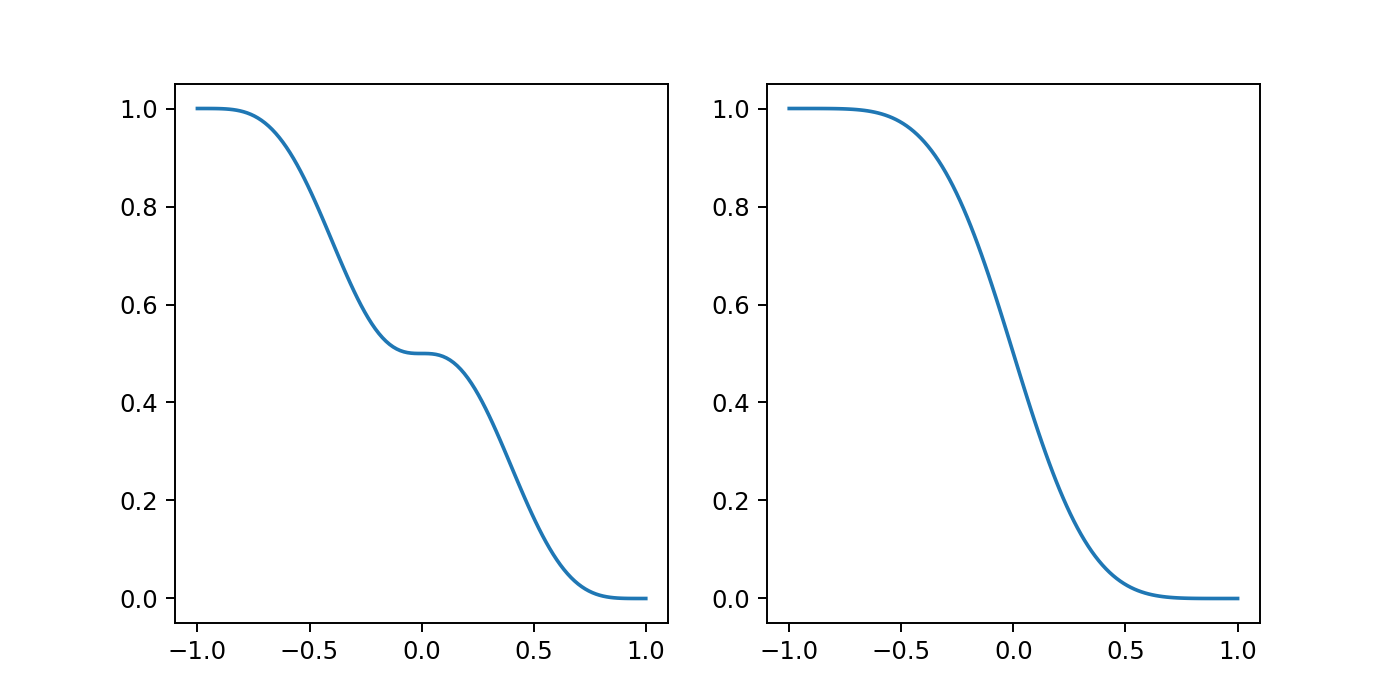

In [195]:
l2 = np.log(-2+0j)
@torch.jit.script
def x2c2(dr, l2 = np.log(-2+0j)):    
#     return 0.
    dd = torch.clone(dr)
    dd[torch.abs(dd) < 1e-5] = 1
    d = torch.complex(torch.abs(dd), dr.new_zeros(dr.shape))
    
    a1 = (-210*d**7-1260*d**5)*torch.log(2*torch.sqrt(1-d**2)+2)
    a2 = (-75*d**7-378*d**5)*torch.log(torch.sqrt(1-d**2)+1)
    a3 = (75*d**7+378*d**5)*torch.log(torch.sqrt(1-d**2)-1)
    a4 = (210*d**7+1260*d**5)*torch.log(d)-24*torch.arccos(d)
    a5 = 210*torch.log(2)*d**7
    a6 = torch.sqrt(1-d**2)*(1880*d**5+544*d**3-24*d)
    a7 = 1260*torch.log(2)*d**5
    
    complexTerm = (a1+a2+a3+a4+a5+a6+a7)/(24*np.pi)
    
    term = complexTerm.real
    term[dr < 0.] = -1 - term[dr < 0.]
    term[torch.abs(dr) < 1e-5] = -0.5

    return -term

@torch.jit.script
def x2s2(dr, l2 = np.log(-2+0j)):    
#     return 0.
    dd = torch.clone(dr)
    dd[torch.abs(dd) < 1e-5] = 1
    d = torch.complex(torch.abs(dd), dr.new_zeros(dr.shape))
    
    a1 = (-210*d**7-1260*d**5)*torch.log(2*torch.sqrt(1-d**2)+2)
    a2 = (75*d**7+378*d**5)*torch.log(torch.sqrt(1-d**2)+1)
    a3 = (-75*d**7-378*d**5)*torch.log(torch.sqrt(1-d**2)-1)
    a4 = (210*d**7+1260*d**5)*torch.log(d)+24*torch.arccos(d)
    a5 = 210*torch.log(2)*d**7
    a6 = torch.sqrt(1-d**2)*(388*d**5+240*d**3-88*d)
    a7 = 1260*torch.log(2)*d**5
        
    complexTerm = -(a1+a2+a3+a4+a5+a6+a7)/(24*np.pi)
    
    term = complexTerm.real
    term[dr < 0.] = -1 - term[dr < 0.]
    term[torch.abs(dr) < 1e-5] = -0.5

    return -term
    

def getCorrelationMatrix(distance, direction, support):
    angle = -torch.atan2(direction[:,1], direction[:,0])
    
#     debugPrint(angle)
    
    s = torch.sin(angle)
    c = torch.cos(angle)
    rot = torch.stack([torch.stack([c,-s]),torch.stack([s,c])]).transpose(0,-1).transpose(1,-1)
#     debugPrint(rot[0,:,:])
    
    term1 = x2c2(distance)
    term2 = x2s2(distance)
#     debugPrint(term1)
#     debugPrint(term2)
#     debugPrint(torch.hstack((term1[:,None], term2[:,None])))
    M = torch.diag_embed(torch.hstack((term1[:,None], term2[:,None])))
    
    rotated = torch.bmm(M, rot)
#     debugPrint(M)
#     debugPrint(rotated)
    return rotated / support[:,None,None]
    
    
getCorrelationMatrix(torch.tensor([0.5,0.5]), torch.tensor([[1,0],[0,1]]), torch.tensor([0.5]))
    
fig, axis = plt.subplots(1,2, figsize=(8,4), squeeze = False, sharey = False)
x = torch.linspace(-1,1,127)

axis[0,0].plot(x,x2c2(x))
x = torch.linspace(-1,1,127)
axis[0,1].plot(x,x2s2(x))
# debugPrint(x2c2)
# print(x)
# debugPrint(x2c2(x))
# debugPrint(x2c2)
# print(x)
# debugPrint(x2c2(x))
# debugPrint(x2c2)
# # x2c2(0.5)

In [6]:
np.log(-2 + 0.j)

(0.6931471805599453+3.141592653589793j)

In [144]:
class Parameter():
    def __init__(self, namespace, name, datatype, defaultValue, required = False, hint = '', export = True):
        self.namespace = namespace
        self.name = name
        self.datatype = datatype
        self.defaultValue = defaultValue
        self.required = required
        self.hint = hint
        self.export = export
        
    def parseConfig(self, config):
        if self.required and self.namespace not in config:
            raise Exception('Parameter Namespace %s missing for required parameter %s.%s' % (self.namespace, self.namespace, self.name))
        elif self.namespace not in config:
            config[self.namespace] = {}
                
        if self.required and self.name not in config[self.namespace]:
            raise Exception('Required parameter %s.%s is missing' % (self.namespace, self.name))
        elif self.name not in config[self.namespace]:
            config[self.namespace][self.name] = self.defaultValue
        
        
            

In [145]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = true
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBC]
periodicX = true
periodicY = true
buffer = 2

[velocitySources]
[velocitySources.one]
min = [-2,-2]
max = [-1,2]
velocity = [0,1]

[emitter]
[emitter.fluidCenter]
fillDomain = false
min = [-1, -1]
max = [ 1,  1]
velocity = [ 0.0, 0.0]

[emitters]
[emitters.fluidLeft]
fillDomain = false
min = [-1.75,-0.5]
max = [-0.75, 0.5]
velocity = [ 1.0, 0.0]
shape = 'sphere'
[emitters.fluidRight]
fillDomain = false
min = [ 0.75,-0.5]
max = [ 1.75, 0.5]
velocity = [-1.0, 0.0]
"""



In [146]:
@torch.jit.script
def wendland(q, support):
    C = 7 / np.pi
#     print(q)
    
    b1 = torch.pow(1. - q, 4)
#     print(b1)
    b2 = 1.0 + 4.0 * q
#     print(b2)
    return b1 * b2 * C / support**2    
@torch.jit.script
def wendlandGrad(q,r,support):
    C = 7 / np.pi
    
    return - r * C / support**3 * (20. * q * (1. -q)**3)[:,None]
   
    
def getKernelFunctions(kernel):
    if kernel == 'wendland2':
        return wendland, wendlandGrad

In [147]:

from scipy.optimize import minimize

def genParticlesCentered(minCoord, maxCoord, radius, support, packing, dtype = torch.float32, device = 'cpu'):
    area = np.pi * radius**2
    
    gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    diff = maxCoord - minCoord
    center = (minCoord + maxCoord) / 2
    requiredSlices = torch.div(torch.ceil(diff / packing / support).type(torch.int64), 2, rounding_mode='floor')
    
    generatedParticles = []
#     print(requiredSlices)
    for i in range(-requiredSlices[0]-1, requiredSlices[0]+2):
        for j in range(-requiredSlices[1]-1, requiredSlices[1]+2):
            p = center
            g = gen_position(packing * support,i,j)
            pos = p + g
            if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2 and \
             pos[0] >= minCoord[0] - support * 0.2 and pos[1] >= minCoord[1] - support * 0.2:
                generatedParticles.append(pos)
                
    return torch.stack(generatedParticles)

def genParticles(minCoord, maxCoord, radius, packing, support, dtype, device):
    with record_function('config - gen particles'):
        area = np.pi * radius**2
#         support = np.sqrt(area * config['targetNeighbors'] / np.pi)
        
        gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    #     packing *= support
        
        diff = maxCoord - minCoord
        requiredSlices = torch.ceil(diff / packing / support).type(torch.int64)
        
    #     print(requiredSlices)
        generatedParticles = []
        for i in range(requiredSlices[0]+1):
            for j in range(requiredSlices[1]+1):
                p = minCoord
                g = gen_position(packing * support,i,j)
                pos = p + g
                if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2:
                    generatedParticles.append(pos)
        particles = torch.stack(generatedParticles)

        return particles


In [148]:

from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

In [149]:
from src.solidBC import *

In [150]:
class Module():
    def getParameters(self):
        return None
    def initialize(self, config, state):
        return
    def finalize(self):
        return
    def __init__(self, identifier, moduleDescription):
        self.description = moduleDescription
        self.name = identifier
        return

In [151]:
class neighborSearchModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
        
    def getParameters(self):
        return [
            Parameter('neighborSearch', 'gradientThreshold', 'float', 1e-7, required = False, export = True, hint = '')
        ]
        
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.maxNeighbors = simulationConfig['compute']['maxNeighbors']
        self.threshold = simulationConfig['neighborSearch']['gradientThreshold']
        
    def search(self, simulationState, simulation):
        with record_function("sph - neighborhood"): 
            row, col = radius(simulationState['fluidPosition'], simulationState['fluidPosition'], self.support, max_num_neighbors = self.maxNeighbors)
            fluidNeighbors = torch.stack([row, col], dim = 0)

            fluidDistances = (simulationState['fluidPosition'][fluidNeighbors[1]] - simulationState['fluidPosition'][fluidNeighbors[0]])
            fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

            fluidDistances[fluidRadialDistances < self.threshold,:] = 0
            fluidDistances[fluidRadialDistances >= self.threshold,:] /= fluidRadialDistances[fluidRadialDistances >= self.threshold,None]
            fluidRadialDistances /= self.support

            return fluidNeighbors, fluidDistances, fluidRadialDistances


In [152]:
class densityModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.kernel, _ = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])
        
    def evaluate(self, simulationState, simulation):
            with record_function("sph - density"): 
                rho =  scatter(self.kernel(simulationState['fluidRadialDistances'], self.support) * \
                            simulationState['fluidArea'][simulationState['fluidNeighbors'][0]], simulationState['fluidNeighbors'][1], dim=0, dim_size=simulationState['numParticles'], reduce="add")

#                 syncQuantity(rho, config, simulationState)    
                return rho
        
    

In [153]:
@torch.jit.script
def LinearCG(H, B, x0, i, j, tol=1e-5, verbose = False):    
    xk = x0
    rk = torch.zeros_like(x0)
    numParticles = rk.shape[0] // 2

    rk[::2]  += scatter(H[:,0,0] * xk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
    rk[::2]  += scatter(H[:,0,1] * xk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")

    rk[1::2] += scatter(H[:,1,0] * xk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
    rk[1::2] += scatter(H[:,1,1] * xk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")
    
    rk = rk - B
    
    pk = -rk
    rk_norm = torch.linalg.norm(rk)
    
    num_iter = 0

    if verbose:
        print('xk: ', x0)
        print('rk: ', rk)
        print('|rk|: ', rk_norm)
        print('pk: ', pk)


    while rk_norm > tol and num_iter < 32:
        apk = torch.zeros_like(x0)

        apk[::2]  += scatter(H[:,0,0] * pk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
        apk[::2]  += scatter(H[:,0,1] * pk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")

        apk[1::2] += scatter(H[:,1,0] * pk[j * 2], i, dim=0, dim_size=numParticles, reduce= "add")
        apk[1::2] += scatter(H[:,1,1] * pk[j * 2 + 1], i, dim=0, dim_size=numParticles, reduce= "add")

        rkrk = torch.dot(rk, rk)
        
        alpha = rkrk / torch.dot(pk, apk)
        xk = xk + alpha * pk
        rk = rk + alpha * apk
        beta = torch.dot(rk, rk) / rkrk
        pk = -rk + beta * pk
        
        num_iter += 1

        rk_norm = torch.linalg.norm(rk)
        if verbose:
            print('iter: ', num_iter)
            print('\t|rk|: ', rk_norm)
            print('\talpha: ', alpha)
            
    return xk



<IPython.core.display.Javascript object>


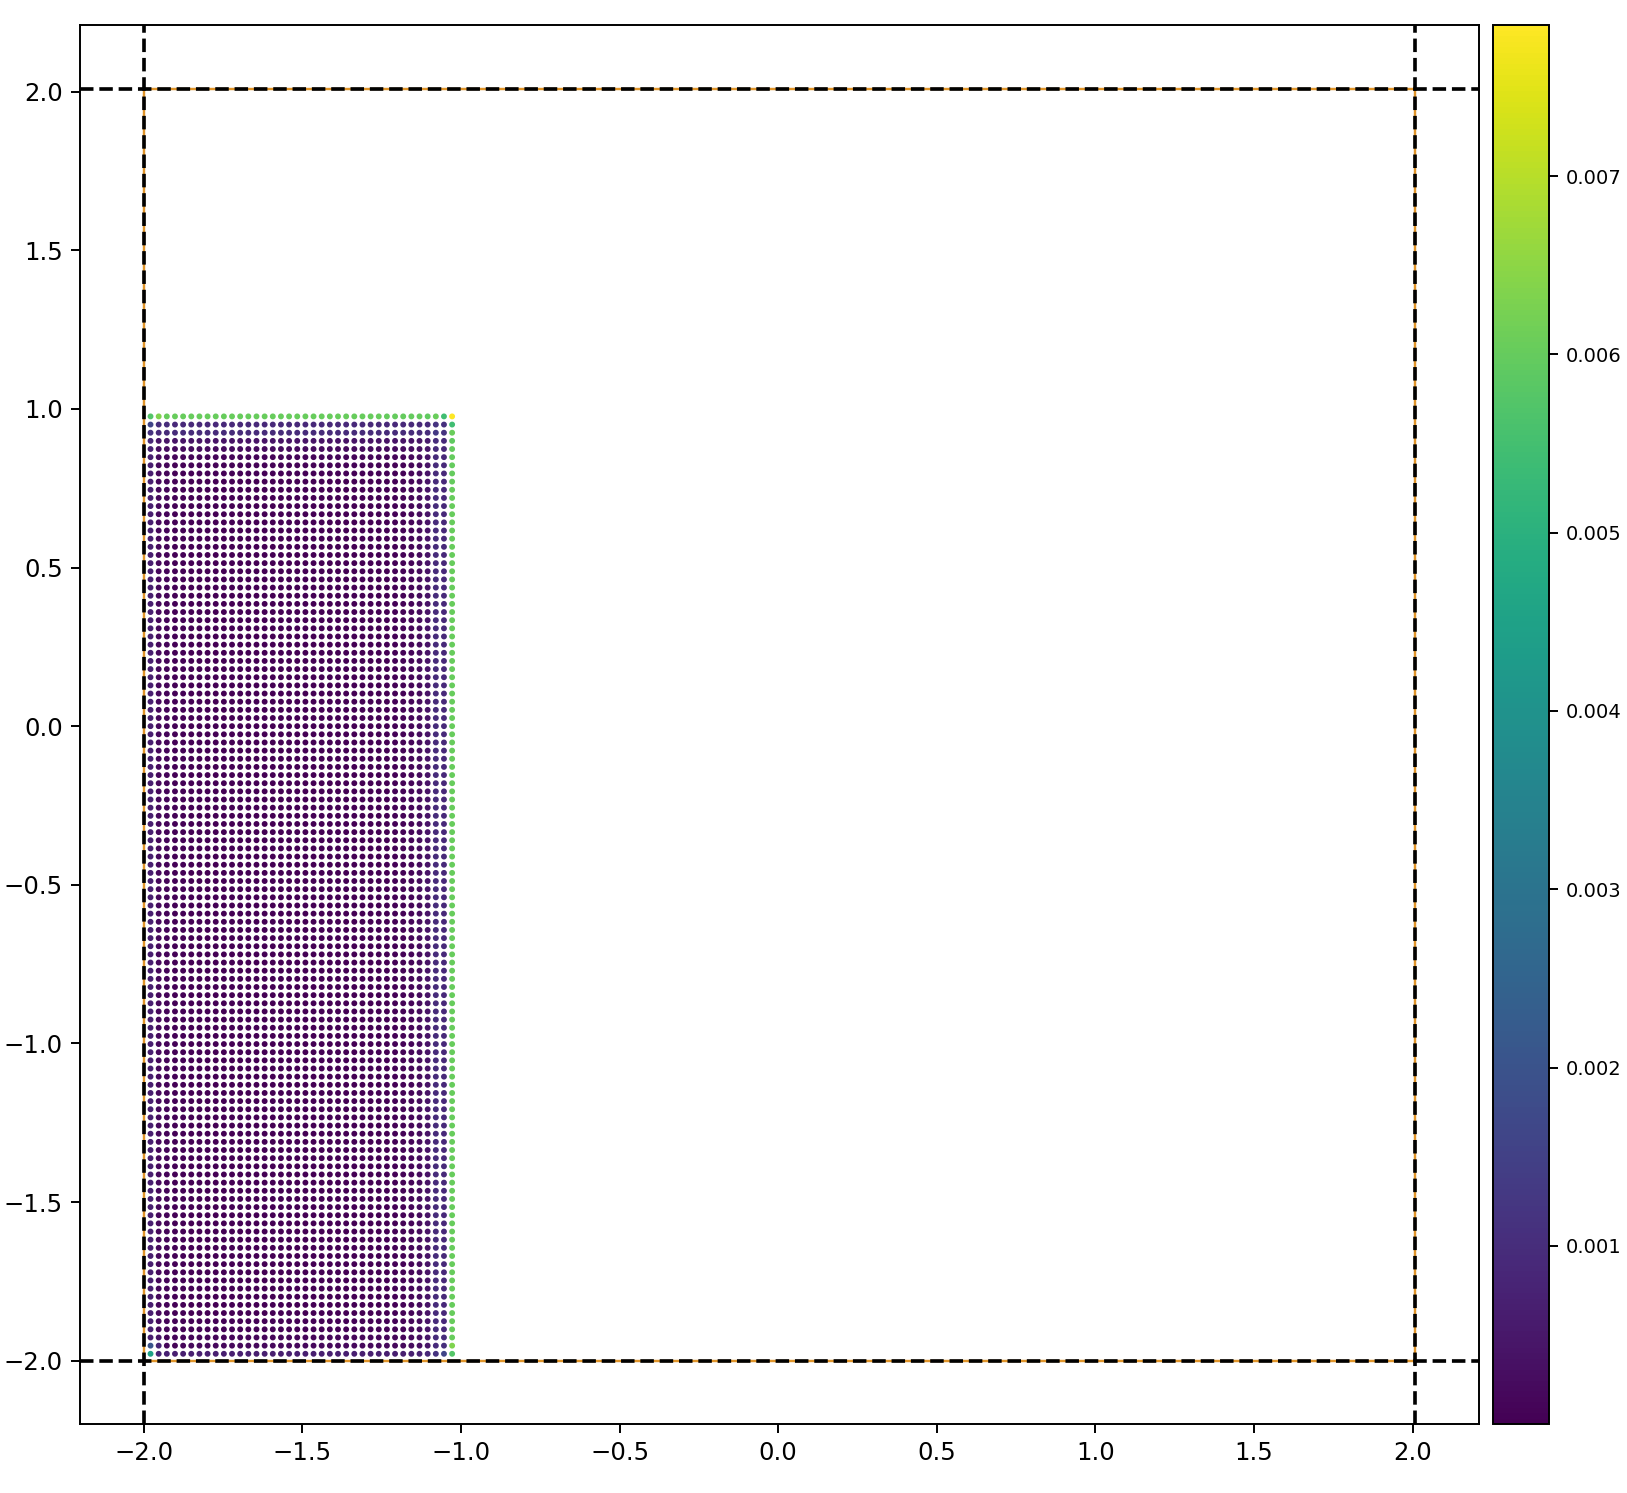

In [240]:
class implicitIterativeShiftModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
       
    def getParameters(self):
        return [
            Parameter('iishifting', 'enabled', 'bool', True, required = False, export = True, hint = ''),
            Parameter('iishifting', 'shiftIterations', 'int', 4, required = False, export = True, hint = ''),
            Parameter('iishifting', 'densityThreshold', 'float', 0.9, required = False, export = True, hint = '')
        ]
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.active = simulationConfig['iishifting']['enabled']
        self.iterations = simulationConfig['iishifting']['shiftIterations']
        self.area = simulationConfig['particle']['area']
        
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        self.threshold = simulationConfig['iishifting']['densityThreshold']
        
        
    def solveShifting(self, simulationState, simulation, verbose = False):
        simulationState['fluidOmegas'] = self.area / simulationState['fluidDensity']
        simulation.periodicBC.syncQuantity(simulationState['fluidOmegas'], simulationState, simulation)

        K, J, H = evalKernel(simulationState['fluidOmegas'], simulationState['fluidPosition'], simulationState['fluidNeighbors'], simulationState['fluidDistances'], simulationState['fluidRadialDistances'], simulationState['numParticles'], self.support)

        JJ = scatter(J, simulationState['fluidNeighbors'][1], dim=0, dim_size=simulationState['numParticles'], reduce= "add")
        JJ -= simulationState['boundaryGradient']

        simulation.periodicBC.syncQuantity(JJ, simulationState, simulation)


        B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
        B[::2] = JJ[:,0]
        B[1::2] = JJ[:,1]


        i = simulationState['fluidNeighbors'][1]
        j = simulationState['fluidNeighbors'][0]

        x0 = torch.rand(simulationState['numParticles'] * 2).to(self.device).type(self.dtype) * self.support / 4
        diff = LinearCG(H, B, x0, i, j, verbose = verbose)

        dx = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
        dy = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
        dx = -diff[::2]
        dy = -diff[1::2]

        update = torch.vstack((dx,dy)).T
#         syncQuantity(update, config, state)
        return update
#         state['fluidUpdate'] = update

    def applyShifting(self, simulationState, simulation):
        if not self.active:
            return
        for i in range(self.iterations):
            simulationState['fluidNeighbors'], simulationState['fluidDistances'], simulationState['fluidRadialDistances'] = \
                simulation.neighborSearch.search(simulationState, simulation)

            simulation.solidBC.filterFluidNeighborhoods(simulationState, simulation)
            
            simulationState['boundaryNeighbors'], simulationState['boundaryDistances'], simulationState['boundaryGradients'], \
                simulationState['boundaryIntegrals'], simulationState['boundaryIntegralGradients'], \
                simulationState['boundaryFluidNeighbors'], simulationState['boundaryFluidPositions'] = simulation.solidBC.search(simulationState, simulation)

            simulationState['fluidDensity'] = simulation.sphDensity.evaluate(simulationState, simulation)  
            simulationState['boundaryDensity'], simulationState['boundaryGradient'] = simulation.solidBC.density(simulationState, simulation)  
            simulationState['fluidDensity'] += simulationState['boundaryDensity']
            simulation.periodicBC.syncQuantity(simulationState['fluidDensity'], simulationState, simulation)
            simulationState['fluidUpdate'] = self.solveShifting(simulationState, simulation)
            simulation.periodicBC.syncQuantity(simulationState['fluidUpdate'], simulationState, simulation)
            
#             simulationState['fluidPosition'][simulationState['fluidDensity'] > self.threshold] += simulationState['fluidUpdate'][simulationState['fluidDensity']>self.threshold]

#             simulation.periodicBC.enforcePeriodicBC(simulationState, simulation)
#             enforcePeriodicBC(config, state)
            return      
        
iiShifting = implicitIterativeShiftModule()
iiShifting.initialize(sphSimulation.config, sphSimulation.simulationState)
iiShifting.applyShifting(sphSimulation.simulationState, sphSimulation)


fig, axis = sphSimulation.createPlot(plotScale = 2)

positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
colors = torch.linalg.norm(sphSimulation.simulationState['fluidUpdate'].detach(),axis=1).cpu().numpy()
# colors = sphSimulation.simulationState['fluidUpdate'].detach().cpu().numpy()


sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = colors, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

distance [Tensor] = tensor([0.3362, 0.3368, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367, 0.3367,
        0.3367, 0.33

<IPython.core.display.Javascript object>


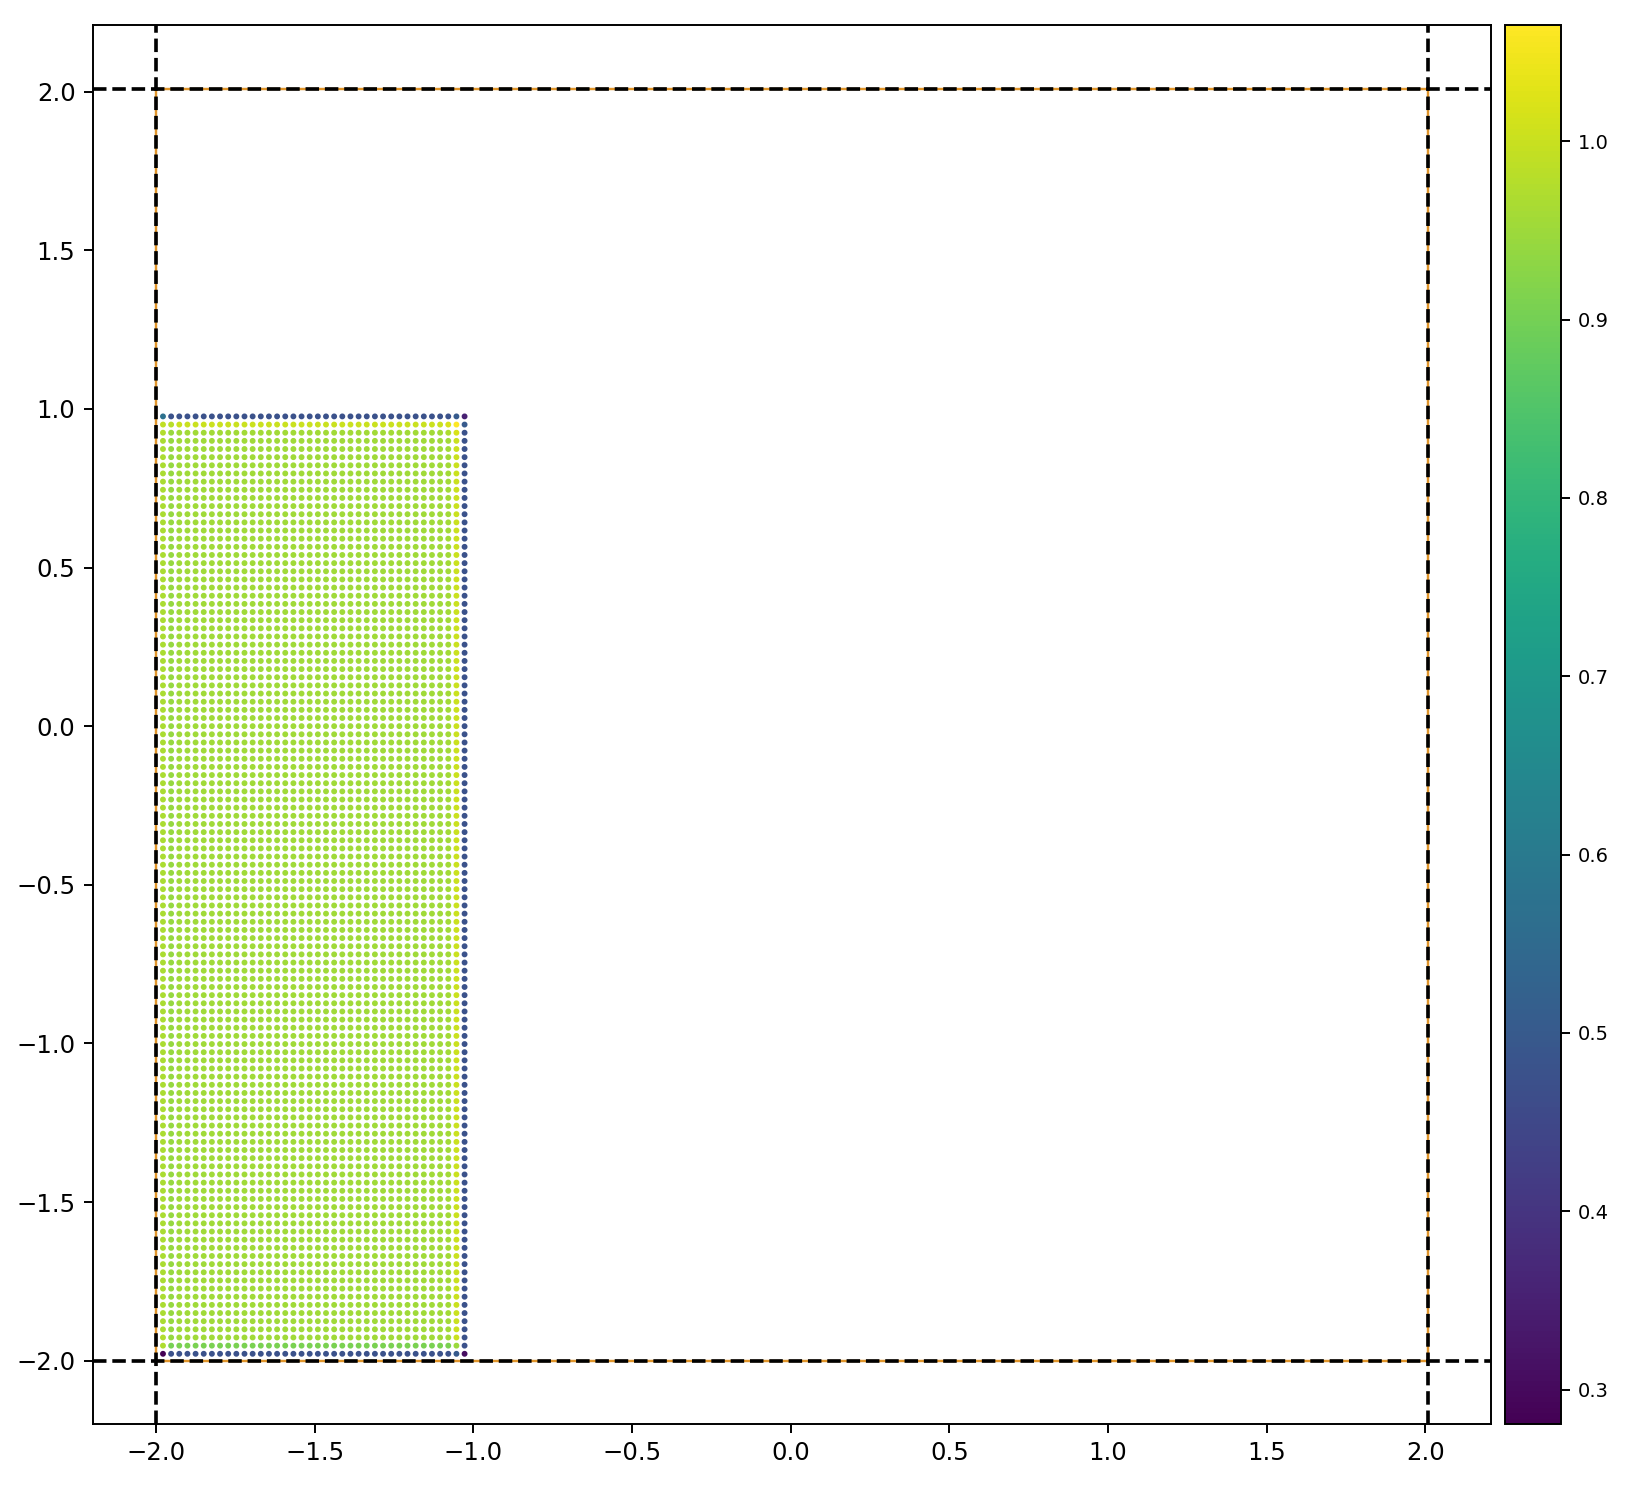

In [273]:
simulationState = sphSimulation.simulationState
simulation = sphSimulation
support = simulation.config['particle']['support']


def getCorrelationMatrix(distance, direction, support):
    angle = -torch.atan2(direction[:,1], direction[:,0])
    debugPrint(distance)
    debugPrint(angle)
    
    s = torch.sin(angle)
    c = torch.cos(angle)
    rot = torch.stack([torch.stack([c,-s]),torch.stack([s,c])]).transpose(0,-1).transpose(1,-1)
#     debugPrint(rot[0,:,:])
    
    term1 = x2c2(distance)
    term2 = x2s2(distance)
#     debugPrint(term1)
#     debugPrint(term2)
#     debugPrint(torch.hstack((term1[:,None], term2[:,None])))
    M = torch.diag_embed(torch.hstack((term1[:,None], term2[:,None])))
    
    M[angle < -0.5,:,:] = 0
    
    rotated = torch.bmm(M, rot)
    debugPrint(rot)
    debugPrint(M)
    debugPrint(rotated)
    
#     M[:,1,1] = -M[:,1,1]
    return 2 * M #/ support[:,None,None]

def computeNormalizationMatrix(simulationState, simulation):
#     global normaliza
    neighbors = simulationState['fluidNeighbors']
    i = neighbors[1]
    j = neighbors[0]
    volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j]

    difference = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
    kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], support)

    term = volume[:,None,None] * torch.einsum('nu,nv -> nuv', difference, kernel)

    normalizationMatrix = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

    neighbors = simulationState['boundaryNeighbors']
    i = neighbors[0]
    b = neighbors[1]

#     bi, bb = simulationState['boundaryFluidNeighbors']

#     pb = simulationState['fluidPosition'][i] - simulationState['boundaryDistances'][:, None] * simulationState['boundaryGradients'] * self.support
    boundaryMatrices = \
        getCorrelationMatrix(simulationState['boundaryDistances'], simulationState['boundaryGradients'], \
                             simulationState['fluidSupport'][i])
    debugPrint(normalizationMatrix)
    normalizationMatrix += scatter(boundaryMatrices,i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#     debugPrint(normalizationMatrix)
    L = torch.linalg.pinv(normalizationMatrix)

    return L, normalizationMatrix

L, M = computeNormalizationMatrix(simulationState, simulation)
lambdas = torch.real(torch.linalg.eigvals(M))

minEV = torch.min(lambdas, axis=1)[0]


fig, axis = sphSimulation.createPlot(plotScale = 2)

positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
# colors = torch.linalg.norm(sphSimulation.simulationState['fluidUpdate'].detach(),axis=1).cpu().numpy()
# colors = sphSimulation.simulationState['fluidUpdate'].detach().cpu().numpy()
colors = torch.min(lambdas, axis=1)[0].detach().cpu().numpy()
# colors = torch.linalg.norm(lambdaGrad.detach(),axis=1).cpu().numpy()

# data = maxAngle.detach().cpu().numpy()
data = minEV.detach().cpu().numpy()
# vectorData = lambdaGrad.detach().cpu().numpy()

# axis[0,0].quiver(positions[:,0], positions[:,1], vectorData[:,0], vectorData[:,1])

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

<IPython.core.display.Javascript object>


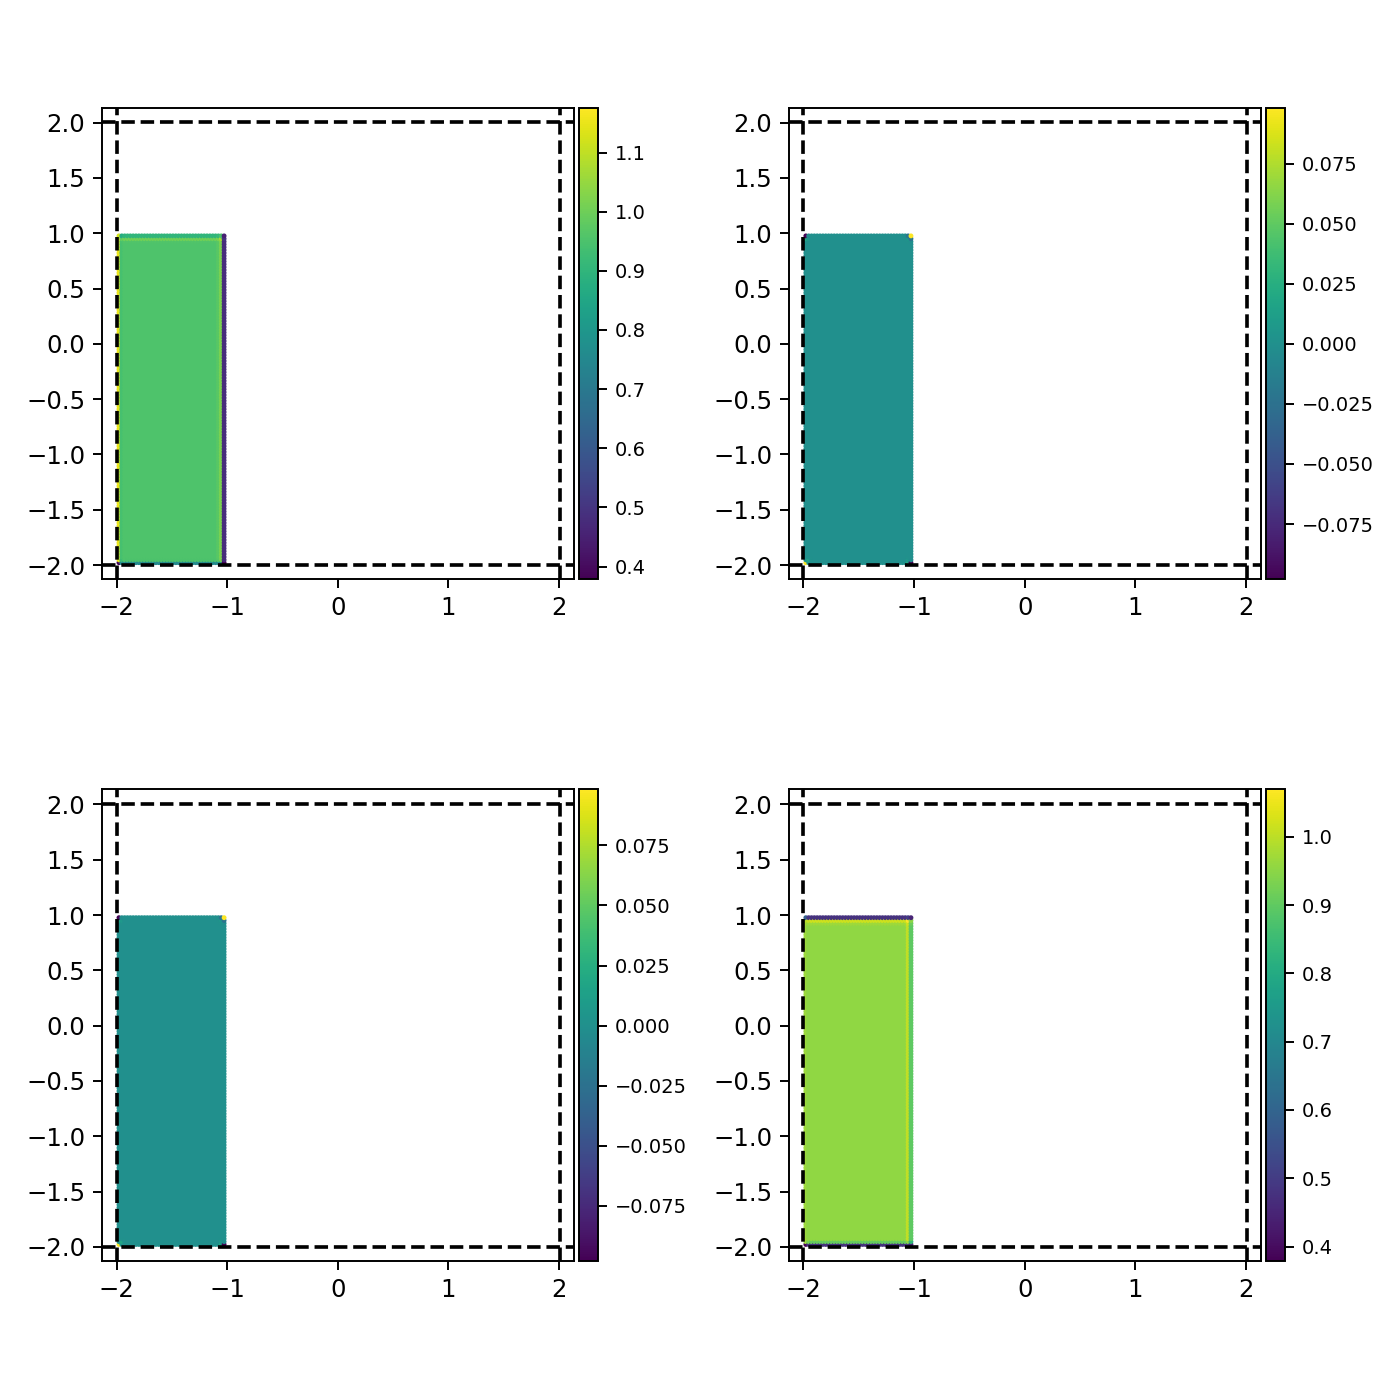

In [275]:
fig, axis = plt.subplots(2,2, figsize=(8,8), squeeze = False, sharey = False)

positions1 = simulationState['fluidPosition'].detach().cpu().numpy()
data1 = M[:,0,0].detach().cpu().numpy()

def scatterPlot(positions, data, axis):
    sc1 = axis.scatter(positions[:,0], positions[:,1], c = data, s = 1)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc1, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_xlim(simulation.config['domain']['virtualMin'][0],simulation.config['domain']['virtualMax'][0])
    axis.set_ylim(simulation.config['domain']['virtualMin'][1],simulation.config['domain']['virtualMax'][1])
    axis.axvline(simulation.config['domain']['min'][0] , ls= '--', c ='black')
    axis.axvline(simulation.config['domain']['max'][0] , ls= '--', c ='black')
    axis.axhline(simulation.config['domain']['min'][1] , ls= '--', c ='black')
    axis.axhline(simulation.config['domain']['max'][1] , ls= '--', c ='black')

scatterPlot(positions1, M[:,0,0].detach().cpu().numpy(), axis[0,0])
scatterPlot(positions1, M[:,0,1].detach().cpu().numpy(), axis[0,1])
scatterPlot(positions1, M[:,1,0].detach().cpu().numpy(), axis[1,0])
scatterPlot(positions1, M[:,1,1].detach().cpu().numpy(), axis[1,1])

fig.tight_layout()

<IPython.core.display.Javascript object>


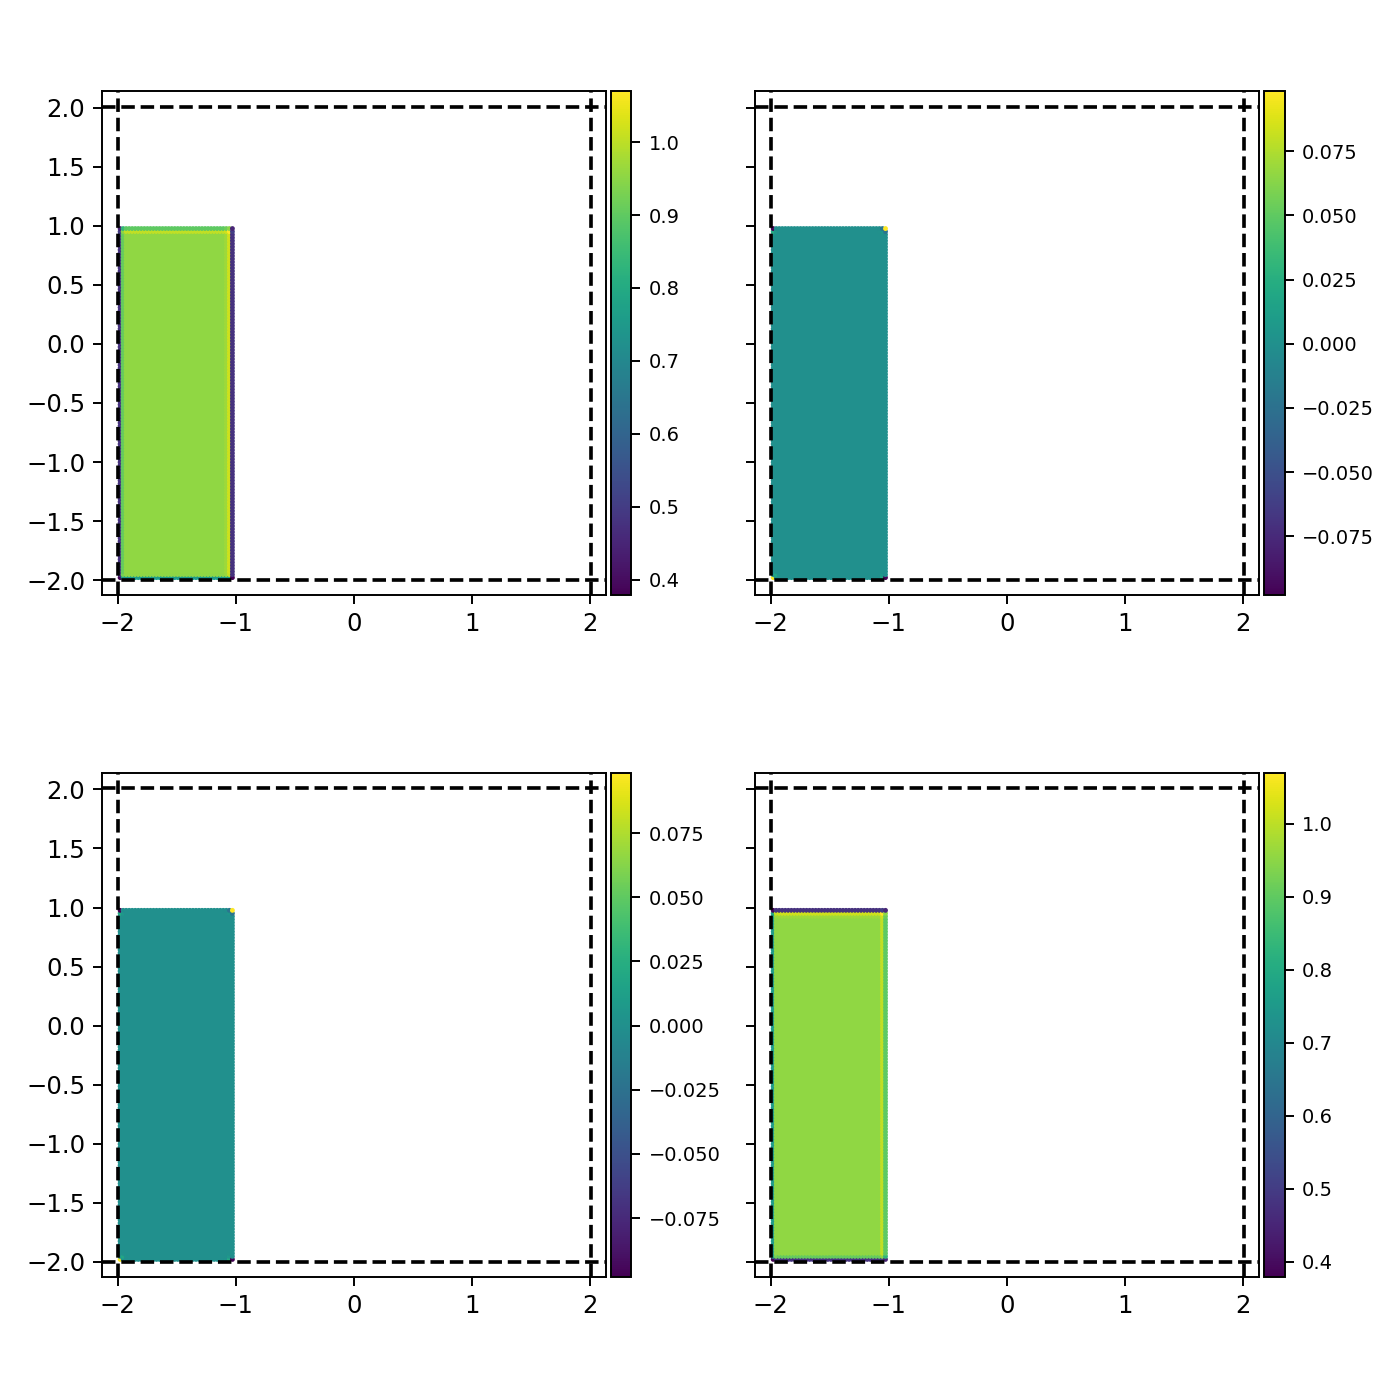

In [270]:
fig, axis = plt.subplots(2,2, figsize=(8,8), squeeze = False, sharey = True)

positions1 = simulationState['fluidPosition'].detach().cpu().numpy()
data1 = M[:,0,0].detach().cpu().numpy()

def scatterPlot(positions, data, axis):
    sc1 = axis.scatter(positions[:,0], positions[:,1], c = data, s = 1)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc1, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_xlim(simulation.config['domain']['virtualMin'][0],simulation.config['domain']['virtualMax'][0])
    axis.set_ylim(simulation.config['domain']['virtualMin'][1],simulation.config['domain']['virtualMax'][1])
    axis.axvline(simulation.config['domain']['min'][0] , ls= '--', c ='black')
    axis.axvline(simulation.config['domain']['max'][0] , ls= '--', c ='black')
    axis.axhline(simulation.config['domain']['min'][1] , ls= '--', c ='black')
    axis.axhline(simulation.config['domain']['max'][1] , ls= '--', c ='black')

scatterPlot(positions1, M[:,0,0].detach().cpu().numpy(), axis[0,0])
scatterPlot(positions1, M[:,0,1].detach().cpu().numpy(), axis[0,1])
scatterPlot(positions1, M[:,1,0].detach().cpu().numpy(), axis[1,0])
scatterPlot(positions1, M[:,1,1].detach().cpu().numpy(), axis[1,1])

fig.tight_layout()

In [157]:
# def computeNormal(simulationState, simulation, minEV, L):
#     neighbors = simulationState['fluidNeighbors']
#     i = neighbors[1]
#     j = neighbors[0]
#     volume = simulationState['fluidArea'][j]/simulationState['fluidDensity'][j]
#     factor = minEV[j] - minEV[i]

# #     print(factor)

#     kernel = simulation.kernelGrad(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], support)

#     correctedKernel = torch.bmm(L[j], kernel[:,:,None])
#     # print(correctedKernel.shape)

#     term = -(volume * factor)[:,None] * correctedKernel[:,:,0]

#     lambdaGrad = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

#     lambdaGradNorm = torch.linalg.norm(lambdaGrad, axis=1)
#     mask = lambdaGradNorm > 1e-3
#     lambdaGrad[mask,:] = lambdaGrad[mask] / lambdaGradNorm[mask,None]
    
#     return lambdaGrad

# lambdaGrad = computeNormal(simulationState, simulation, minEV, L)

In [158]:

# neighbors = simulationState['fluidNeighbors']
# i = neighbors[1, neighbors[1] != neighbors[0]]
# j = neighbors[0, neighbors[1] != neighbors[0]]


# difference = simulationState['fluidPosition'][j] - simulationState['fluidPosition'][i]
# nVs = difference / torch.norm(difference, p=2, dim=-1, keepdim=True)
# normal = lambdaGrad[i]

# cos_ij = torch.einsum('nd,nd->n', nVs, normal)
# term = torch.acos(cos_ij)

# maxAngle = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="min")

# maxAngle[maxAngle < np.pi/6] = 0
# maxAngle[maxAngle >= np.pi/6] = 1
# maxAngle[minEV >= 0.9] = 0

In [159]:
# minLambda = torch.min(lambdas, axis=1)[0]
# debugPrint(minLambda)

<IPython.core.display.Javascript object>


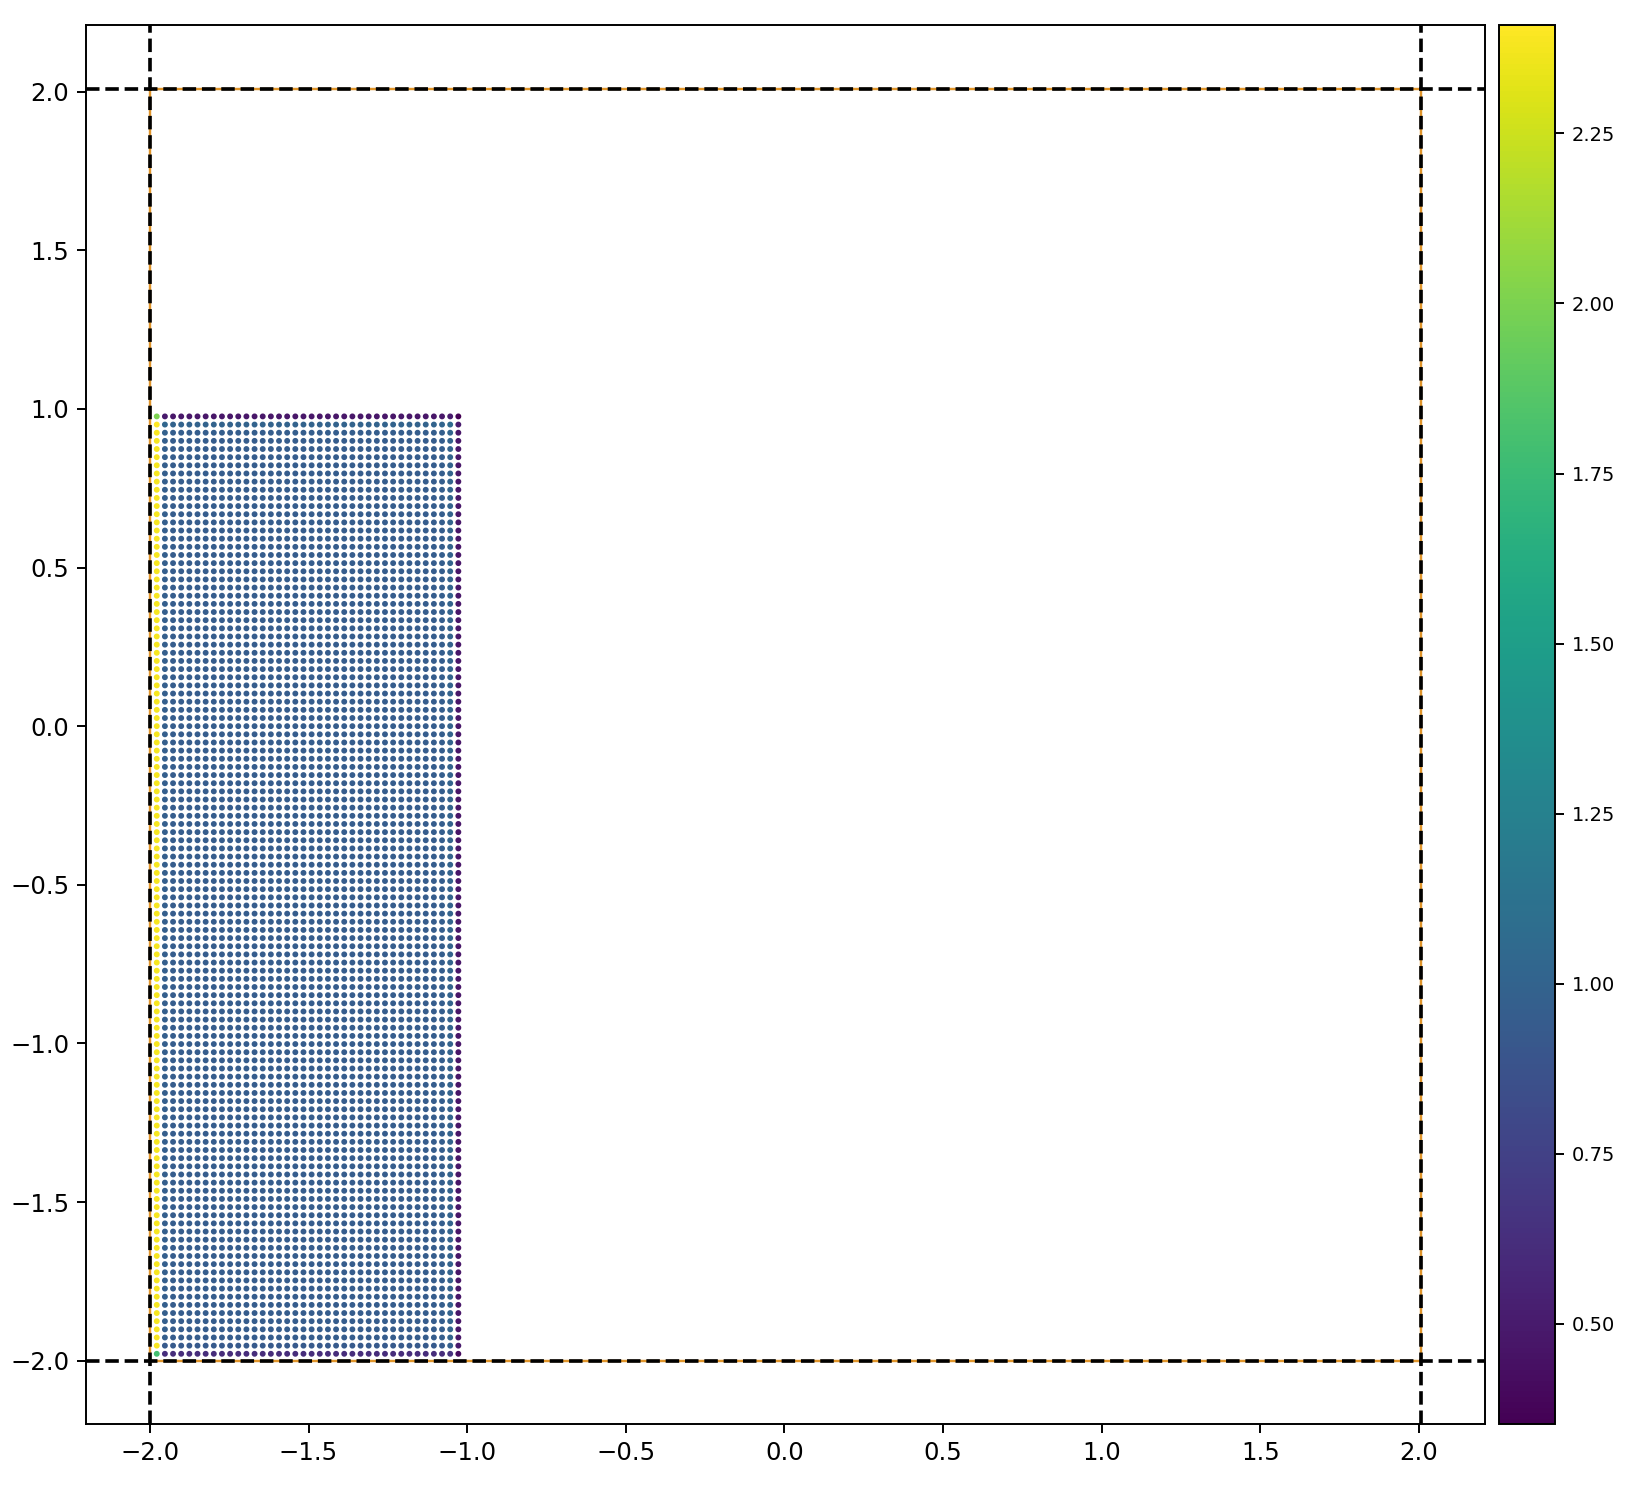

In [194]:

fig, axis = sphSimulation.createPlot(plotScale = 2)

positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
# colors = torch.linalg.norm(sphSimulation.simulationState['fluidUpdate'].detach(),axis=1).cpu().numpy()
# colors = sphSimulation.simulationState['fluidUpdate'].detach().cpu().numpy()
colors = torch.min(lambdas, axis=1)[0].detach().cpu().numpy()
# colors = torch.linalg.norm(lambdaGrad.detach(),axis=1).cpu().numpy()

# data = maxAngle.detach().cpu().numpy()
data = minEV.detach().cpu().numpy()
# vectorData = lambdaGrad.detach().cpu().numpy()

# axis[0,0].quiver(positions[:,0], positions[:,1], vectorData[:,0], vectorData[:,1])

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

In [161]:
# print(difference.shape)

# debugPrint(difference[1])
# debugPrint(kernel[1])
# debugPrint(torch.outer(difference[1], kernel[1]))

In [162]:

#     def fluidTerm(self, simulationState, simulation):
#         with record_function("sph - xsph correction"): 
#             neighbors = simulationState['fluidNeighbors']
#             i = neighbors[1]
#             j = neighbors[0]

#             fac = self.fluidCoefficient * simulationState['fluidRestDensity'][j] * simulationState['fluidArea'][j]
#             rho_i = simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i]
#             rho_j = simulationState['fluidDensity'][j] * simulationState['fluidRestDensity'][j]

#             v_ij = simulationState['fluidVelocity'][j] - simulationState['fluidVelocity'][i]

#             k = wendland(simulationState['fluidRadialDistances'], self.support)

#             term = (fac / (rho_i + rho_j) * 2. * k)[:,None] * v_ij

#             correction = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
# #             syncQuantity(correction, config, simulationState)

#             return correction

In [163]:
class solidBCModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
        
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.active = True if 'solidBC' in simulationConfig else False
        self.maxNeighbors = simulationConfig['compute']['maxNeighbors']
        if not self.active:
            return
        self.numBodies = len(simulationConfig['solidBC'])
        self.boundaryObjects = simulationConfig['solidBC']
        simulationState['solidBC'] =  simulationConfig['solidBC']
        self.kernel, _ = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])
#         print(self.numBodies)
        
#         self.periodicX = simulationConfig['periodicBC']['periodicX']
#         self.periodicY = simulationConfig['periodicBC']['periodicY']
#         self.buffer = simulationConfig['periodicBC']['buffer']
#         self.domainMin = simulationConfig['domain']['virtualMin']
#         self.domainMax = simulationConfig['domain']['virtualMax']
#         self.dtype = simulationConfig['compute']['precision']
        
        
    def search(self, simulationState, simulation):
        if not self.active:
            return None, None, None, None, None, None, None
        with record_function('solidBC - neighborhood'):
            particleIndices = torch.arange(simulationState['numParticles'], device = simulation.device, dtype = torch.int64 )

            sdfDistances = []
            sdfGradients = []
            sdfRows = []
            sdfCols = []
            sdfIntegrals = []
            sdfIntegralDerivatives = []
            sdfFluidNeighbors = []
            sdfFluidNeighborsRows = []
            sdfFluidNeighborsCols = []
            sdfNeighbors = []


            for ib, bdy in enumerate(simulationState['solidBC']):
                b = simulationState['solidBC'][bdy]
                polyDist, polyDer, bIntegral, bGrad = sdPolyDerAndIntegral(b['polygon'], simulationState['fluidPosition'], self.support, inverted = b['inverted'])

                adjacent = polyDist <= self.support
                polyDer = polyDer / torch.linalg.norm(polyDer,axis=1)[:,None]
                polyDist = polyDist / self.support
                if polyDer[adjacent].shape[0] == 0:
                    continue

                i = particleIndices[adjacent]
                j = torch.ones(i.shape, device = simulation.device, dtype = torch.int64) *ib

                pb = simulationState['fluidPosition'][adjacent] - polyDist[adjacent, None] * polyDer[adjacent,:] * self.support
        #         print(polyDist[adjacent])
        #         print(polyDer[adjacent])
        #         print(pb)

                row, col = radius(pb, simulationState['fluidPosition'], self.support, max_num_neighbors = self.maxNeighbors)

                # for ib, b in enumerate(config['solidBoundary']):
                #     i = col
                #     j = row

                #     polyDist, polyDer, polyDerLen = sdPolyDer(b['polygon'], pb, config, inverted = b['inverted'])
                #     cp = pb - polyDist[:,None] * polyDer
                #     d = torch.einsum('nd,nd->n', polyDer, cp)
                #     neighDistances = torch.einsum('nd,nd->n', simulationState['fluidPosition'][j], polyDer[i]) - d[i]

                #     col = col[neighDistances >= 0]
                #     row = row[neighDistances >= 0]

                    # fluidNeighbors = torch.vstack((j,i))


        #         print('pb', pb.shape, pb)
        #         print('row', row.shape, row)
        #         print('col', col.shape, col)


        #         print(row,col)

                pbNeighbors = torch.stack([row, col], dim = 0)
        #         print(pbNeighbors)


                sdfDistances.append(polyDist[adjacent])
                sdfGradients.append(polyDer[adjacent])
                sdfIntegrals.append(bIntegral[adjacent])
                sdfIntegralDerivatives.append(bGrad[adjacent])
                # sdfFluidNeighbors.append(pbNeighbors)
                sdfRows.append(i)
                sdfCols.append(j)
                sdfFluidNeighborsRows.append(row)
                sdfFluidNeighborsCols.append(col)
            if len(sdfRows) > 0:
                boundaryDistances = torch.cat(sdfDistances)
                boundaryGradients = torch.cat(sdfGradients)
                sdfRows = torch.cat(sdfRows)
                sdfCols = torch.cat(sdfCols)
                boundaryNeighbors = torch.stack((sdfRows, sdfCols))
                sdfFluidNeighborsRows = torch.cat(sdfFluidNeighborsRows)
                sdfFluidNeighborsCols = torch.cat(sdfFluidNeighborsCols)
                boundaryFluidNeighbors = torch.stack((sdfFluidNeighborsRows, sdfFluidNeighborsCols))
                boundaryIntegrals = torch.cat(sdfIntegrals)
                boundaryIntegralGradients = torch.cat(sdfIntegralDerivatives)
                # boundaryFluidNeighbors = torch.cat(sdfFluidNeighbors)
                del particleIndices

                neighbors = boundaryNeighbors
                i = neighbors[0]
                b = neighbors[1]

                pb = simulationState['fluidPosition'][i] - boundaryDistances[:, None] * boundaryGradients * self.support

        #         print('i', i.shape, i)
        #         print('b', b.shape, b)
        #         print('pb', pb.shape, pb)

                bi, bb  = boundaryFluidNeighbors
        #         print('bi', bi.shape, bi)
        #         print('bb', bb.shape, bb)

                distances = torch.linalg.norm(simulationState['fluidPosition'][bi] - pb[bb], axis = 1) / self.support
        #         print('distances', distances.shape, distances)
        #         print('kernel', wendland(distances, config['support']))
                fac = simulationState['fluidArea'][bi] * self.kernel(distances, self.support)

        #         print('fac', fac.shape, fac)
        #         print('distances', distances.shape, distances)

                d_sum = scatter(fac, bb, dim = 0, dim_size = pb.shape[0])
        #         print('d_bar', d_bar.shape, d_bar)
                d_bar = scatter(fac[:,None] * simulationState['fluidPosition'][bi], bb, dim = 0, dim_size = pb.shape[0])
        #         print('d_sum', d_sum.shape, d_sum)
        #         print('d_sum', d_sum.shape, d_sum)
        #         print('d_bar', d_bar.shape, d_bar)
                d_bar[d_sum > 0,:] /= d_sum[d_sum > 0,None]


        #         print('bi', bi.shape, bi)
        #         print('bb', bb.shape, bb)
        #         print('distances', distances.shape, distances)
        #         print('d_bar', d_bar.shape, d_bar)
        #         print('pb', pb.shape, pb)
                x_b = pb - d_bar
        #         print('x_b', x_b.shape, x_b)

        #         x_b *= simulationState['fluidRestDensity']

        #         row, col = radius(x_b, simulationState['fluidPosition'], config['support'], max_num_neighbors = config['max_neighbors'])
        #         boundaryFluidNeighbors = torch.stack([row, col], dim = 0)
        #         print('row', row)
        #         print('col', col)

        #         print(pbNeighbors)

                return boundaryNeighbors, boundaryDistances, boundaryGradients, boundaryIntegrals, boundaryIntegralGradients, boundaryFluidNeighbors, d_bar
            else:
                return None, None, None, None, None, None, None
    
    def filterFluidNeighborhoods(self, simulationState, simulation):        
        if self.active:
            for ib, bdy in enumerate(simulationState['solidBC']):
                b = simulationState['solidBC'][bdy]
                i = simulationState['fluidNeighbors'][1]
                j = simulationState['fluidNeighbors'][0]

                polyDist, polyDer, _, _, _, _ = sdPolyDer(b['polygon'], simulationState['fluidPosition'], inverted = b['inverted'])
                cp = simulationState['fluidPosition'] - polyDist[:,None] * polyDer
                d = torch.einsum('nd,nd->n', polyDer, cp)
                neighDistances = torch.einsum('nd,nd->n', simulationState['fluidPosition'][j], polyDer[i]) - d[i]

                i = i[neighDistances >= 0]
                j = j[neighDistances >= 0]

                simulationState['fluidNeighbors'] = torch.vstack((j,i))
                simulationState['fluidDistances'] = simulationState['fluidDistances'][neighDistances >= 0]
                simulationState['fluidRadialDistances'] = simulationState['fluidRadialDistances'][neighDistances >= 0]


    def density(self, simulationState, simulation):
        density = torch.zeros(simulationState['fluidDensity'].shape, device=simulation.device, dtype= simulation.dtype)
        gradient = torch.zeros(simulationState['fluidPosition'].shape, device=simulation.device, dtype= simulation.dtype)
        if 'boundaryNeighbors' in simulationState and simulationState['boundaryNeighbors'] != None:

            density = scatter(simulationState['boundaryIntegrals'], simulationState['boundaryNeighbors'][0], dim = 0, dim_size = simulationState['numParticles'], reduce="add")
            gradient = scatter(simulationState['boundaryIntegralGradients'], simulationState['boundaryNeighbors'][0], dim = 0, dim_size = simulationState['numParticles'], reduce="add")
            
        return density, gradient

# solidBC = solidBCModule()
# solidBC.initialize(sphSimulation.config, sphSimulation.simulationState)
# solidBC.filterFluidNeighborhoods(sphSimulation.simulationState, sphSimulation)
# solidBC.search(sphSimulation.simulationState, sphSimulation)
# solidBC.density(sphSimulation.simulationState, sphSimulation)   
        

In [164]:
class xsphModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('xsph', 'fluidViscosity', 'float', 0.01, required = False, export = True, hint = ''),
            Parameter('xsph', 'boundaryViscosity', 'float', 0.01, required = False, export = True, hint = '')
        ]
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.dtype = simulationConfig['compute']['precision']
        
        self.fluidCoefficient = simulationConfig['xsph']['fluidViscosity']
        self.boundaryCoefficient = simulationConfig['xsph']['boundaryViscosity']
        return
    
    def fluidTerm(self, simulationState, simulation):
        with record_function("sph - xsph correction"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]

            fac = self.fluidCoefficient * simulationState['fluidRestDensity'][j] * simulationState['fluidArea'][j]
            rho_i = simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i]
            rho_j = simulationState['fluidDensity'][j] * simulationState['fluidRestDensity'][j]

            v_ij = simulationState['fluidVelocity'][j] - simulationState['fluidVelocity'][i]

            k = wendland(simulationState['fluidRadialDistances'], self.support)

            term = (fac / (rho_i + rho_j) * 2. * k)[:,None] * v_ij

            correction = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
#             syncQuantity(correction, config, simulationState)

            return correction
    def boundaryTerm(self, simulationState, simulation):
        with record_function('solidBC - friction'):
            # print(state)
            # print(state['boundaryNeighbors'])
            if 'boundaryNeighbors' in state and state['boundaryNeighbors'] != None:
                neighbors = state['boundaryNeighbors']
                i = neighbors[0]
                b = neighbors[1]
                sdfs = state['boundaryDistances']
                sdfgrads = state['boundaryGradients']

            #     print(i.shape)
            #     print(b.shape)
            #     print(sdfs.shape)
            #     print(sdfgrads.shape)

                fluidVelocity = state['fluidVelocity'][i]

            #     print(fluidVelocity.shape)

                fluidVelocityOrthogonal = torch.einsum('nd, nd -> n', fluidVelocity, sdfgrads)[:,None] * sdfgrads
                fluidVelocityParallel = fluidVelocity - fluidVelocityOrthogonal
            #     print(fluidVelocity)
            #     print(fluidVelocityOrthogonal)
            #     print(fluidVelocityParallel)
                velocities = []
                for bb in simulationState['solidBC']:
                    sb = simulationState['solidBC'][bb]
                    if 'velocity' in sb:
                        velocities.append(torch.tensor(sb['velocity'],device=simulation.device,dtype=self.dtype))
                    else:
                        velocities.append(torch.tensor([0,0],device=simulation.device,dtype=self.dtype))

                boundaryVelocities = torch.stack(velocities)
                fac = self.boundaryCoefficient * state['fluidRestDensity'][i]
                rho_i = state['fluidDensity'][i] * state['fluidRestDensity'][i]
                rho_b = state['fluidRestDensity'][i]

                v_ib = boundaryVelocities[b] - fluidVelocityParallel

                k = state['boundaryIntegrals']

                term = (fac / (rho_i + rho_b))[:,None] * v_ib

                correction = scatter(term, i, dim = 0, dim_size=state['numParticles'], reduce='add')
                # print(correction[i])

    #             state['fluidVelocity'] += correction
                force = -correction / simulationState['dt'] * (state['fluidArea'] * state['fluidRestDensity'])[:,None]
                state['boundaryFrictionForce'] = scatter(force[i], b, dim = 0, dim_size = len(simulationState['solidBC']), reduce = "add")

                return correction

        

# xsph = xsphModule()
# xsph.initialize(sphSimulation.config, sphSimulation.simulationState)
# xsph.fluidTerm(sphSimulation.simulationState, sphSimulation)
# xsph.boundaryTerm(sphSimulation.simulationState, sphSimulation)
        

In [165]:
class gravityModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('gravity', 'magnitude', 'float', 9.81, required = False, export = True, hint = ''),
            Parameter('gravity', 'direction', 'float array', [0, -1], required = False, export = True, hint = ''),
            Parameter('gravity', 'pointSource', 'bool', False, required = False, export = True, hint = ''),
            Parameter('gravity', 'center', 'float array', [0, 0], required = False, export = True, hint = ''),
        ]
    def initialize(self, simulationConfig, simulationState):
        self.magnitude = simulationConfig['gravity']['magnitude']
        self.direction = simulationConfig['gravity']['direction']
        self.pointSource = simulationConfig['gravity']['pointSource']
        self.center = simulationConfig['gravity']['center']
        
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        return
    
    def evaluate(self, simulationState, simulation):
        if self.pointSource:
            difference = simulationState['fluidPosition'] - self.center
            distance = torch.linalg.norm(difference,axis=1)
            difference[distance > 1e-5] = difference[distance > 1e-5] / distance[distance > 1e-5]
            return -self.magnitude * difference
        else:
            return self.magnitude * torch.tensor(self.direction, device = self.device, dtype = self.dtype)

In [166]:
class velocityBCModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def getParameters(self):
        return [
            Parameter('xsph', 'fluidViscosity', 'float', 0.01, required = False, export = True, hint = ''),
            Parameter('xsph', 'boundaryViscosity', 'float', 0.01, required = False, export = True, hint = '')
        ]
    def initialize(self, simulationConfig, simulationState):
        if 'velocitySource' not in simulationConfig:
            return
        self.support = simulationConfig['particle']['support']
        self.dtype = simulationConfig['compute']['precision']
        self.device = simulationConfig['compute']['device']
        
        simulationState['velocitySource'] = simulationConfig['velocitySource']
        return
    
    def enforce(self, simulationState, simulation):
        if not 'velocitySource' in simulationState:
            return
        with record_function('velocityBC - enforcing'):
            state['fluidGamma'] = torch.ones(state['fluidArea'].shape, device=self.device, dtype=self.dtype)
            for s in simulationState['velocitySource']:
                source = simulationState['velocitySource'][s]
            #     print(source)
                velTensor = torch.tensor(source['velocity'], device=self.device, dtype=self.dtype)
                curSpeed = velTensor if source['rampTime']>0. else velTensor * np.clip(state['time'] / source['rampTime'], a_min = 0., a_max = 1.)
            #     print(curSpeed)

                xmask = torch.logical_and(state['fluidPosition'][:,0] >= source['min'][0], state['fluidPosition'][:,0] <= source['max'][0])
                ymask = torch.logical_and(state['fluidPosition'][:,1] >= source['min'][1], state['fluidPosition'][:,1] <= source['max'][1])

                mask = torch.logical_and(xmask, ymask)

                active = torch.any(mask)
                # print(xmask)
                # print(ymask)
                # print(mask)
                # print(active)
            #     print(mask)
            #     print(torch.any(mask))
                mu = 3.5
                xr = (state['fluidPosition'][:,0] - source['min'][0]) / (source['max'][0] - source['min'][0])

                if source['min'][0] < 0:
                    xr = 1 - xr

                gamma = (torch.exp(torch.pow(torch.clamp(xr,min = 0, max = 1), mu)) - 1) / (np.exp(1) - 1)

                # gamma = 1 - (torch.exp(torch.pow(xr,mu)) - 1) / (np.exp(1) - 1)
                state['fluidGamma'] = torch.min(gamma, state['fluidGamma'])
                if active:
                    # print(gamma.shape)
                    # gamma = gamma[mask]
                    state['fluidVelocity'][mask,:] = state['fluidVelocity'][mask,:] * (1 - gamma)[mask,None] + gamma[mask,None] * curSpeed


            #     print('\n')


        

# velBC = velocityBCModule()
# velBC.initialize(sphSimulation.config, sphSimulation.simulationState)
# velBC.enforce(sphSimulation.simulationState, sphSimulation)
        

In [167]:
class periodicBCModule(Module):
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
        
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.periodicX = simulationConfig['periodicBC']['periodicX']
        self.periodicY = simulationConfig['periodicBC']['periodicY']
        self.buffer = simulationConfig['periodicBC']['buffer']
        self.domainMin = simulationConfig['domain']['min']
        self.domainMax = simulationConfig['domain']['max']
        self.virtualMin = simulationConfig['domain']['virtualMin']
        self.virtualMax = simulationConfig['domain']['virtualMax']
        self.dtype = simulationConfig['compute']['precision']
        
    def filterVirtualParticles(self, positions, state):    
        with record_function('periodicBC - filtering'):

            counter = torch.zeros(state['numParticles'], dtype=torch.int64).to(positions.device)
            uidCounter = scatter(torch.ones(state['numParticles'], dtype=torch.int64).to(positions.device), state['UID'], dim = 0, dim_size=state['realParticles'])

            if self.periodicX:
                counter[positions[:,0] < self.domainMin[0]] = -1
                counter[positions[:,0] >= self.domainMax[0]] = -1
            if self.periodicY:        
                counter[positions[:,1] < self.domainMin[1]] = -1    
                counter[positions[:,1] >= self.domainMax[1]] = -1

            deletionCounter = scatter(counter, state['UID'], dim = 0, dim_size=state['realParticles'])
            actualCounter = uidCounter + deletionCounter
            problematicUIDs = state['UID'][:state['realParticles']][actualCounter != 1]
            indices = torch.ones(state['numParticles'], dtype = torch.int64, device=positions.device) * -1
            indices[counter != -1] = state['UID'][counter != -1]

            tempUIDs = torch.arange(state['numParticles'], dtype=torch.int64, device=positions.device)
            for uid in problematicUIDs:
                relevantIndices = tempUIDs[state['UID'] == uid]
                relevantPositions = positions[relevantIndices,:]
                clippedPositions = positions[relevantIndices,:]
                clippedPositions[:,0] = torch.clamp(clippedPositions[:,0], min = self.domainMin[0], max = self.domainMax[0])
                clippedPositions[:,1] = torch.clamp(clippedPositions[:,1], min = self.domainMin[1], max = self.domainMax[1])
                distances = torch.linalg.norm(clippedPositions - relevantPositions, axis =1)
                iMin = torch.argmin(distances)
                for i in range(relevantIndices.shape[0]):
                    indices[relevantIndices[i]] = state['UID'][relevantIndices[i]] if i == iMin else -1
                    positions[relevantIndices[i]] = clippedPositions[i] if i == iMin else positions[relevantIndices[i]]

            indices = tempUIDs[indices != -1]
            args = torch.argsort(state['UID'][indices])
            indices = indices[args]

            return indices

        
    def createGhostParticles(self, positions):
        with record_function('periodicBC - creating ghost particles'):
            indices = torch.arange(positions.shape[0], dtype=torch.int64).to(positions.device)
            virtualMin = self.domainMin
            virtualMax = self.domainMax

            mask_xp = positions[:,0] >= virtualMax[0] - self.buffer * self.support
            mask_xn = positions[:,0] < virtualMin[0] + self.buffer * self.support
            mask_yp = positions[:,1] >= virtualMax[1] - self.buffer * self.support
            mask_yn = positions[:,1] < virtualMin[1] + self.buffer * self.support

            filter_xp = indices[mask_xp]
            filter_xn = indices[mask_xn]
            filter_yp = indices[mask_yp]
            filter_yn = indices[mask_yn]

            mask_xp_yp = torch.logical_and(mask_xp, mask_yp)
            mask_xp_yn = torch.logical_and(mask_xp, mask_yn)
            mask_xn_yp = torch.logical_and(mask_xn, mask_yp)
            mask_xn_yn = torch.logical_and(mask_xn, mask_yn)

            filter_xp_yp = indices[torch.logical_and(mask_xp, mask_yp)]
            filter_xp_yn = indices[torch.logical_and(mask_xp, mask_yn)]
            filter_xn_yp = indices[torch.logical_and(mask_xn, mask_yp)]
            filter_xn_yn = indices[torch.logical_and(mask_xn, mask_yn)]

            main = filter_xp.shape[0] + filter_xn.shape[0] + filter_yp.shape[0] + filter_yn.shape[0]
            corner = filter_xp_yp.shape[0] + filter_xp_yn.shape[0] + filter_xn_yp.shape[0] + filter_xn_yn.shape[0]

            ghosts_xp = torch.zeros((filter_xp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xp[:,0] -=  virtualMax[0] - virtualMin[0]

            ghosts_yp = torch.zeros((filter_yp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_yp[:,1] -=  virtualMax[1] - virtualMin[1]

            ghosts_xn = torch.zeros((filter_xn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xn[:,0] +=  virtualMax[0] - virtualMin[0]

            ghosts_yn = torch.zeros((filter_yn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_yn[:,1] +=  virtualMax[1] - virtualMin[1]


            ghosts_xp_yp = torch.zeros((filter_xp_yp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xp_yp[:,0] -=  virtualMax[0] - virtualMin[0]
            ghosts_xp_yp[:,1] -=  virtualMax[1] - virtualMin[1]

            ghosts_xp_yn = torch.zeros((filter_xp_yn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xp_yn[:,0] -=  virtualMax[0] - virtualMin[0]
            ghosts_xp_yn[:,1] +=  virtualMax[1] - virtualMin[1]

            ghosts_xn_yp = torch.zeros((filter_xn_yp.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xn_yp[:,0] +=  virtualMax[0] - virtualMin[0]
            ghosts_xn_yp[:,1] -=  virtualMax[1] - virtualMin[1]

            ghosts_xn_yn = torch.zeros((filter_xn_yn.shape[0], positions.shape[1]), dtype = self.dtype, device = positions.device)
            ghosts_xn_yn[:,0] +=  virtualMax[0] - virtualMin[0]
            ghosts_xn_yn[:,1] +=  virtualMax[1] - virtualMin[1]

            filters = []
            offsets = []
            if self.periodicX:
                filters.append(filter_xp)
                filters.append(filter_xn)
                offsets.append(ghosts_xp)
                offsets.append(ghosts_xn)
            if self.periodicY:
                filters.append(filter_yp)
                filters.append(filter_yn)
                offsets.append(ghosts_yp)
                offsets.append(ghosts_yn)
            if self.periodicX and self.periodicY:
                filters.append(filter_xp_yp)
                filters.append(filter_xp_yn)
                filters.append(filter_xn_yp)
                filters.append(filter_xn_yn)
                offsets.append(ghosts_xp_yp)
                offsets.append(ghosts_xp_yn)
                offsets.append(ghosts_xn_yp)
                offsets.append(ghosts_xn_yn)

            return filters, offsets
        
    def enforcePeriodicBC(self, simulationState, simulation):
        with record_function('periodicBC - enforce BC'):
            if self.periodicX or self.periodicX:
                if not 'realParticles' in simulationState:
                    simulationState['realParticles'] = simulationState['numParticles']
        #         print('Old Particle Count: ', simulationState['numParticles'] )
                realParticles = self.filterVirtualParticles(simulationState['fluidPosition'], simulationState)
                for arr in simulationState:
                    if not torch.is_tensor(simulationState[arr]):
                        continue
                    if simulationState[arr].shape[0] == simulationState['numParticles']:
                        simulationState[arr] = simulationState[arr][realParticles]

                simulationState['numParticles'] = simulationState['fluidPosition'].shape[0]
                if 'realParticles' in simulationState:
                    if simulationState['realParticles'] != simulationState['fluidPosition'].shape[0]:
                        print('panik, deleted or removed actual particles at time', simulationState['time'])

                simulationState['realParticles'] = simulationState['fluidPosition'].shape[0]
        #         print('After pruning: ', simulationState['numParticles'] )




                ghostIndices, ghostOffsets = self.createGhostParticles(simulationState['fluidPosition'])

                ghostIndices = torch.cat(ghostIndices)
                ghostOffsets = torch.vstack(ghostOffsets)

                realParticles = self.filterVirtualParticles(simulationState['fluidPosition'], simulationState)
                for arr in simulationState:
                    if not torch.is_tensor(simulationState[arr]):
                        continue
                    if simulationState[arr].shape[0] == simulationState['numParticles']:
                        if arr == 'fluidPosition':
                            simulationState[arr] = torch.cat((simulationState[arr],simulationState[arr][ghostIndices] + ghostOffsets))
                        else:
                            simulationState[arr] = torch.cat((simulationState[arr],simulationState[arr][ghostIndices]))

                simulationState['numParticles'] = simulationState['fluidPosition'].shape[0]
        #         print('New Particle Count: ', simulationState['numParticles'] )

                ones = torch.ones(simulationState['realParticles'], dtype = torch.int64, device=simulation.device) * -1
                simulationState['ghostIndices'] = torch.cat((ones, ghostIndices))
                simulationState['ghosts'] = ghostIndices
        
    def syncQuantity(self, qty, simulationState, simulation):
        with record_function('periodicBC - syncing quantity'):
            if self.periodicX or self.periodicX:
                ghosts = simulationState['ghosts']
                qty[simulationState['numParticles'] - ghosts.shape[0]:] = qty[simulationState['ghosts']]

# periodicBC = periodicBCModule()
# periodicBC.initialize(sphSimulation.config, sphSimulation.simulationState)
# periodicBC.enforcePeriodicBC(sphSimulation.simulationState, sphSimulation)
# periodicBC.syncQuantity(sphSimulation.simulationState['fluidDensity'], sphSimulation.simulationState, sphSimulation)

In [168]:


def mlsInterpolation(simulationState, simulation, queryPositions, support):
    # queryPositions = simulationState['fluidPosition']
    # queryPosition = pb
    # support = simulation.config['particle']['support'] * 2

    i, j = radius(simulationState['fluidPosition'], queryPositions, support, max_num_neighbors = 256)
    neighbors = torch.stack([i, j], dim = 0)

#     debugPrint(neighbors)
    # debugPrint(torch.min(neighbors[0]))
    # debugPrint(torch.max(neighbors[0]))
    # debugPrint(torch.min(neighbors[1]))
    # debugPrint(torch.max(neighbors[1]))

    distances = (simulationState['fluidPosition'][j] - queryPositions[i])
    radialDistances = torch.linalg.norm(distances,axis=1)

    distances[radialDistances < 1e-5,:] = 0
    distances[radialDistances >= 1e-5,:] /= radialDistances[radialDistances >= 1e-5,None]
    radialDistances /= support

    kernel = wendland(radialDistances, support)

    bij = simulationState['fluidPosition'][j] - queryPositions[i]
    bij = torch.hstack((bij.new_ones((bij.shape[0]))[:,None], bij))
#     debugPrint(bij)

    Mpartial = 2 * torch.einsum('nu, nv -> nuv', bij, bij) * \
            (simulationState['fluidArea'][j] / simulationState['fluidDensity'][j] * kernel)[:,None,None]

    M = scatter(Mpartial, i, dim=0, dim_size = queryPositions.shape[0], reduce='add')
    Minv = torch.linalg.pinv(M)
#     debugPrint(Minv)

    e1 = torch.tensor([1,0,0], dtype=Minv.dtype, device=Minv.device)
    Me1 = torch.matmul(Minv,e1)
#     debugPrint(Me1)


    pGpartial = torch.einsum('nd, nd -> n', Me1[i], bij) * \
        kernel * simulationState['fluidPressure2'][j] * (simulationState['fluidArea'][j] / simulationState['fluidDensity'][j])

    pG = scatter(pGpartial, i, dim=0, dim_size = queryPositions.shape[0], reduce='add')
#     debugPrint(pG)
    
    return pG


In [169]:
class dfsphModule(Module):
    def getParameters(self):
        return [
            Parameter('dfsph', 'minDensitySolverIterations', 'int', 2, required = False, export = True, hint = ''),
            Parameter('dfsph', 'minDivergenceSolverIterations', 'int', 2, required = False, export = True, hint = ''),
            Parameter('dfsph', 'maxDensitySolverIterations', 'int', 256, required = False, export = True, hint = ''),
            Parameter('dfsph', 'maxDivergenceSolverIterations', 'int', 8, required = False, export = True, hint = ''),
            Parameter('dfsph', 'densityThreshold', 'float', 1e-4, required = False, export = True, hint = ''),
            Parameter('dfsph', 'divergenceThreshold', 'float', 1e-2, required = False, export = True, hint = ''),
            Parameter('dfsph', 'divergenceSolver', 'bool', False, required = False, export = True, hint = ''),
            Parameter('dfsph', 'relaxedJacobiOmega', 'float', 0.5, required = False, export = True, hint = '')
        ]
        
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.kernel, self.gradientKernel = getKernelFunctions(simulationConfig['kernel']['defaultKernel'])
        
        self.minDensitySolverIterations = simulationConfig['dfsph']['minDensitySolverIterations']
        self.minDivergenceSolverIterations = simulationConfig['dfsph']['minDivergenceSolverIterations']
        self.maxDensitySolverIterations = simulationConfig['dfsph']['maxDensitySolverIterations']
        self.maxDivergenceSolverIterations = simulationConfig['dfsph']['maxDivergenceSolverIterations']
        self.densityThreshold = simulationConfig['dfsph']['densityThreshold']
        self.divergenceThreshold = simulationConfig['dfsph']['divergenceThreshold']
#         self.divergenceSolver - simulationConfig['dfsph']['divergenceSolver']
        self.relaxedJacobiOmega = simulationConfig['dfsph']['relaxedJacobiOmega']
    
        self.backgroundPressure = simulationConfig['fluid']['backgroundPressure']
        
        self.boundaryCounter = len(simulationConfig['solidBC']) if 'solidBC' in simulationConfig else 0
        
        
    def computeAlpha(self, simulationState, simulation, density = True):
        with record_function("dfsph - compute alpha"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            grad2 = torch.einsum('nd, nd -> n', grad, grad)

            term1 = simulationState['fluidActualArea'][j][:,None] * grad
            term2 = simulationState['fluidActualArea'][j]**2 / (simulationState['fluidArea'][j] * simulationState['fluidRestDensity'][j]) * grad2

            kSum1 = scatter(term1, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")
            kSum2 = scatter(term2, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'boundaryNeighbors' in simulationState and simulationState['boundaryNeighbors'] != None:
                kSum1 += simulationState['boundaryGradient']

            fac = - simulationState['dt'] **2 * simulationState['fluidActualArea']
            mass = simulationState['fluidArea'] * simulationState['fluidRestDensity']

            return fac / mass * torch.einsum('nd, nd -> n', kSum1, kSum1) + fac * kSum2

    def computeSourceTerm(self, simulationState, simulation, density = True):
        with record_function("dfsph - compute source term"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            fac = - simulationState['dt'] * simulationState['fluidActualArea'][j]
            vij = simulationState['fluidPredictedVelocity'][i] - simulationState['fluidPredictedVelocity'][j]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)
            prod = torch.einsum('nd, nd -> n', vij, grad)

            source = scatter(fac * prod, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'boundaryNeighbors' in simulationState and simulationState['boundaryNeighbors'] != None:
                source = source - simulationState['dt'] * torch.einsum('nd, nd -> n',  simulationState['fluidPredictedVelocity'],  simulationState['boundaryGradient'])

            return 1. - simulationState['fluidDensity'] + source if density else source


    def computeUpdatedPressure(self, simulationState, simulation, density = True):
        with record_function("dfsph - update pressure"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

            fac = simulationState['dt']**2 * simulationState['fluidActualArea'][j]
            aij = simulationState['fluidPredAccel'][i] - simulationState['fluidPredAccel'][j]
            kernelSum = scatter(torch.einsum('nd, nd -> n', fac[:,None] * aij, grad), i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'boundaryNeighbors' in simulationState and simulationState['boundaryNeighbors'] != None:
                kernelSum = kernelSum + simulationState['dt']**2 * torch.einsum('nd, nd -> n', simulationState['fluidPredAccel'], simulationState['boundaryGradient'])


            residual = kernelSum - simulationState['fluidSourceTerm']

            pressure = simulationState['fluidPressure'] - self.relaxedJacobiOmega * residual / simulationState['fluidAlpha']
            pressure = torch.clamp(pressure, min = 0.) if density else pressure
            if density and self.backgroundPressure:
                pressure = torch.clamp(pressure, min = (5**2) * simulationState['fluidRestDensity'])


            return pressure, residual


    def computeAcceleration(self, simulationState, simulation, density = True):
        with record_function("dfsph - compute accel"): 
            neighbors = simulationState['fluidNeighbors']
            i = neighbors[1]
            j = neighbors[0]
            grad = self.gradientKernel(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], self.support)

            fac = - simulationState['fluidArea'][j] * simulationState['fluidRestDensity'][j]
            pi = simulationState['fluidPressure2'][i] / (simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i])**2
            pj = simulationState['fluidPressure2'][j] / (simulationState['fluidDensity'][j] * simulationState['fluidRestDensity'][j])**2
            term = (fac * (pi + pj))[:,None] * grad
            fluidAccelTerm = scatter(term, i, dim=0, dim_size=simulationState['numParticles'], reduce="add")

            if density and 'boundaryNeighbors' in simulationState and simulationState['boundaryNeighbors'] != None:
                with record_function("dfsph - compute accel boundary"): 
                    neighbors = simulationState['boundaryNeighbors']
                    i = neighbors[0]
                    b = neighbors[1]

                    boundaryPressure = simulationState['fluidPressure2'][i]

                    bi, bb = simulationState['boundaryFluidNeighbors']

                    pb = simulationState['fluidPosition'][i] - simulationState['boundaryDistances'][:, None] * simulationState['boundaryGradients'] * self.support
#                     simulationState['pb'] = pb
#             #         print(pb.shape)
#             #         print('bi', bi.shape, bi)
#             #         print('bb', bb.shape, bb)

#                     distances = torch.linalg.norm(simulationState['fluidPosition'][bi] - pb[bb], axis = 1) / self.support
#             #         print('distances', distances.shape, distances)
#             #         print('kernel', wendland(distances, config['support']))

#                     kernel = wendland(distances, self.support)
#                     pjb = simulationState['fluidPosition'][bi] - simulationState['boundaryFluidPositions'][bb]

#                     Mpartial = torch.einsum('nd, ne -> nde', pjb, pjb)
#             #         print('Mpartial', Mpartial.shape, Mpartial)

#                     M = scatter(Mpartial, bb, dim=0, dim_size = pb.shape[0], reduce='add')

#             #         print('pjb', pjb.shape, pjb)

#                     vecSum = scatter(pjb * (simulationState['fluidPressure2'][bi] * simulationState['fluidArea'][bi] * kernel)[:,None], bb, dim=0, dim_size = pb.shape[0], reduce='add')
#                     sumA = scatter(simulationState['fluidPressure2'][bi] * simulationState['fluidArea'][bi] * kernel, bb, dim=0, dim_size = pb.shape[0], reduce='add')
#                     sumB = scatter(simulationState['fluidArea'][bi] * kernel, bb, dim=0, dim_size = pb.shape[0], reduce='add')

#             #         print('M', M.shape, M)
#             #         print('vecSum', vecSum.shape, vecSum)
#             #         print('sumA', sumA.shape, sumA)
#             #         print('sumB', sumB.shape, sumB)

#                     fac = simulationState['fluidArea'][bi] * wendland(distances, self.support)

#                     Mp = torch.linalg.pinv(M)

#                     alpha = sumA / sumB
#                     beta  = Mp[:,0,0] * vecSum[:,0] + Mp[:,0,1] * vecSum[:,1]
#                     gamma = Mp[:,1,0] * vecSum[:,0] + Mp[:,1,1] * vecSum[:,1]

#                     det = torch.linalg.det(Mp)

#                     simulationState['boundary sumA'] = sumA
#                     simulationState['boundary sumB'] = sumB
#                     simulationState['boundary vecSum'] = vecSum
#                     simulationState['boundary alpha'] = alpha
#                     simulationState['boundary beta'] = beta
#                     simulationState['boundary gamma'] = gamma
#                     simulationState['boundary det'] = det
#                     simulationState['boundary M'] = M
#                     simulationState['boundary Mp'] = Mp

#                     beta[torch.isnan(det)] = 0
#                     gamma[torch.isnan(det)] = 0

#                     boundaryPressure = alpha + beta * simulationState['boundaryFluidPositions'][:,0] + gamma * simulationState['boundaryFluidPositions'][:,1]
#             #         print(boundaryPressure)
#                     boundaryPressure[torch.isnan(alpha)] = 0
#                     boundaryPressure[torch.isnan(boundaryPressure)] = 0     

                    simulationState['boundaryPressure'] = mlsInterpolation(simulationState, simulation, pb, self.support * 2) 

#                     boundaryPressure = simulationState['fluidPressure2'][i]

                    fac = - simulationState['fluidRestDensity'][i]
                    pi = simulationState['fluidPressure2'][i] / (simulationState['fluidDensity'][i] * simulationState['fluidRestDensity'][i])**2
                    pb = boundaryPressure / (1. * simulationState['fluidRestDensity'][i])**2
                    grad = simulationState['boundaryIntegralGradients']

                    boundaryAccelTerm = scatter((fac * (pi + pb))[:,None] * grad, simulationState['boundaryNeighbors'][0], dim = 0, dim_size = simulationState['numParticles'], reduce="add")

                    simulationState['boundaryAccelTerm'] = boundaryAccelTerm

                    boundaryAccelTerm2 = scatter((fac * (pb + pb))[:,None] * grad, simulationState['boundaryNeighbors'][0], dim = 0, dim_size = simulationState['numParticles'], reduce="add")

                    force = -boundaryAccelTerm2 * (simulationState['fluidArea'] * simulationState['fluidRestDensity'])[:,None]
                    simulationState['boundaryPressureForce'] = scatter(force[i], b, dim = 0, dim_size = self.boundaryCounter, reduce = "add")

                    return fluidAccelTerm + boundaryAccelTerm

            return fluidAccelTerm


    def densitySolve(self, simulationState, simulation):
        with record_function("dfsph - density solver"): 
            errors = []
            i = 0
            error = 0.
            minIters = self.minDensitySolverIterations
            if 'densityErrors' in simulationState:
                minIters = max(minIters, len(simulationState['densityErrors'])*0.75)

            while((i < minIters or \
                    error > self.densityThreshold) and \
                    i <= self.maxDensitySolverIterations):
                
                with record_function("dfsph - density solver iteration"): 
                    simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, True)
                    simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
                    simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

                    simulationState['fluidPressure2'], simulationState['residual'] = self.computeUpdatedPressure(simulationState, simulation, True)
                    
                    simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)

                    error = torch.mean(torch.clamp(simulationState['residual'], min = -self.densityThreshold))# * simulationState['fluidArea'])

                    errors.append((error).item())
                    i = i + 1
            simulationState['densityErrors'] = errors
            simulationState['densitySolverPressure'] = simulationState['fluidPressure']
            return errors

    def divergenceSolve(self, simulationState, simulation):
        with record_function("dfsph - divergence solver"): 
            errors = []
            i = 0
            error = 0.
            while((i < self.minDivergenceSolverIterations or error > self.divergenceThreshold) and i <= self.maxDivergenceSolverIterations):
                with record_function("dfsph - divergence solver iteration"): 
                    simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, False)
                    simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
                    simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

                    simulationState['fluidPressure2'], simulationState['residual'] = self.computeUpdatedPressure(simulationState, simulation, False)
                    simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)

                    error = torch.mean(torch.clamp(simulationState['residual'], min = -self.divergenceThreshold))# * simulationState['fluidArea'])

                    errors.append((error).item())
                    i = i + 1
            simulationState['divergenceErrors'] = errors
            simulationState['divergenceSolverPressure'] = simulationState['fluidPressure']
            return errors


    def DFSPH(self, simulationState, simulation, density = True): 
        with record_function("dfsph - solver"): 
            simulationState['fluidPredAccel'] = torch.zeros(simulationState['fluidPosition'].shape, dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)
            simulationState['fluidPredictedVelocity'] = simulationState['fluidVelocity'] + simulationState['dt'] * simulationState['fluidAcceleration']
            simulationState['fluidActualArea'] = simulationState['fluidArea'] / simulationState['fluidDensity']

            simulationState['fluidAlpha'] = self.computeAlpha(simulationState, simulation, density)
            simulation.periodicBC.syncQuantity(simulationState['fluidAlpha'], simulationState, simulation)
            
            simulationState['fluidSourceTerm'] = self.computeSourceTerm(simulationState, simulation, density)
            simulation.periodicBC.syncQuantity(simulationState['fluidSourceTerm'], simulationState, simulation)
            if 'densitySolverPressure' in simulationState and density:
                simulationState['fluidPressure2'] = simulationState['densitySolverPressure'] * 0.5
            else:
                simulationState['fluidPressure2'] = torch.zeros(simulationState['numParticles'], dtype = simulationState['fluidPosition'].dtype, device = simulationState['fluidPosition'].device)

            simulation.periodicBC.syncQuantity(simulationState['fluidPressure2'], simulationState, simulation)
            totalArea = torch.sum(simulationState['fluidArea'])

            if density:
                errors = self.densitySolve(simulationState, simulation)
            else:
                errors = self.divergenceSolve(simulationState, simulation)
        #         print(error / totalArea)
        #     print(i, ["{0:0.5f}".format(i) for i in errors])
            simulationState['fluidPredAccel'] = self.computeAcceleration(simulationState, simulation, density)
            simulation.periodicBC.syncQuantity(simulationState['fluidPredAccel'], simulationState, simulation)
            simulationState['fluidPressure'][:] = simulationState['fluidPressure2'][:]

            simulationState['fluidPredictedVelocity'] += simulationState['dt'] * simulationState['fluidPredAccel']
        #     print(density, errors)
            return errors
        
    def incompressibleSolver(self, simulationState, simulation):
        return self.DFSPH(simulationState, simulation, True)
    def divergenceSolver(self, simulationState, simulation):
        return self.DFSPH(simulationState, simulation, False)
    
# dfsph = dfsphModule()
# dfsph.initialize(sphSimulation.config, sphSimulation.simulationState)
# # dfsph.divergenceSolver(sphSimulation.simulationState, sphSimulation)
# dfsph.incompressibleSolver(sphSimulation.simulationState, sphSimulation)

In [170]:
# simulation = sphSimulation
# simulationState = sphSimulation.simulationState

# neighbors = simulationState['boundaryNeighbors']
# i = neighbors[0]
# b = neighbors[1]

# boundaryPressure = simulationState['fluidPressure2'][i]

# bi, bb = simulationState['boundaryFluidNeighbors']

# pb = simulationState['fluidPosition'][i] - simulationState['boundaryDistances'][:, None] * simulationState['boundaryGradients'] * support

# pG = mlsInterpolation(simulationState, simulation, pb, simulation.config['particle']['support'])

In [171]:
# fig, axis = plt.subplots(1,2, figsize=(8,4), squeeze = False, sharey = True)

# positions1 = simulationState['fluidPosition'].detach().cpu().numpy()
# data1 = simulationState['fluidPressure2'].detach().cpu().numpy()


# sc1 = axis[0,0].scatter(positions1[:,0], positions1[:,1], c = data1, s = 2)
# axis[0,0].axis('equal')
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc1, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 
# axis[0,0].set_xlim(simulation.config['domain']['virtualMin'][0],simulation.config['domain']['virtualMax'][0])
# axis[0,0].set_ylim(simulation.config['domain']['virtualMin'][1],simulation.config['domain']['virtualMax'][1])
# axis[0,0].axvline(simulation.config['domain']['min'][0] , ls= '--', c ='black')
# axis[0,0].axvline(simulation.config['domain']['max'][0] , ls= '--', c ='black')
# axis[0,0].axhline(simulation.config['domain']['min'][1] , ls= '--', c ='black')
# axis[0,0].axhline(simulation.config['domain']['max'][1] , ls= '--', c ='black')


# positions2 = pb.detach().cpu().numpy()
# data2 = pG.detach().cpu().numpy()

# sc2 = axis[0,1].scatter(positions2[:,0], positions2[:,1], c = data2, s = 2)
# axis[0,1].axis('equal')
# ax1_divider = make_axes_locatable(axis[0,1])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc2, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 
# axis[0,1].set_xlim(simulation.config['domain']['virtualMin'][0],simulation.config['domain']['virtualMax'][0])
# axis[0,1].set_ylim(simulation.config['domain']['virtualMin'][1],simulation.config['domain']['virtualMax'][1])
# axis[0,1].axvline(simulation.config['domain']['min'][0] , ls= '--', c ='black')
# axis[0,1].axvline(simulation.config['domain']['max'][0] , ls= '--', c ='black')
# axis[0,1].axhline(simulation.config['domain']['min'][1] , ls= '--', c ='black')
# axis[0,1].axhline(simulation.config['domain']['max'][1] , ls= '--', c ='black')




# fig.tight_layout()

In [172]:
# simulation = sphSimulation
# simulationState = sphSimulation.simulationState



# neighbors = simulationState['boundaryNeighbors']
# i = neighbors[0]
# b = neighbors[1]

# boundaryPressure = simulationState['fluidPressure2'][i]

# bi, bb = simulationState['boundaryFluidNeighbors']

# pb = simulationState['fluidPosition'][i] - simulationState['boundaryDistances'][:, None] * simulationState['boundaryGradients'] * support

# # distances = torch.linalg.norm(simulationState['fluidPosition'][bi] - pb[bb], axis = 1) / support/

# distances = torch.linalg.norm(simulationState['fluidPosition'][bi] - simulationState['fluidPosition'][bb], axis = 1) / support
# kernel = wendland(distances, support)
# #         print('distances', distances.shape, distances)
# #         print('kernel', wendland(distances, config['support']))

# bij = simulationState['fluidPosition'][bi] - simulationState['fluidPosition'][bb]
# # debugPrint(bij)
# bij = torch.hstack((bij.new_ones((bij.shape[0]))[:,None], bij))
# # debugPrint(bij)

# Mpartial = torch.einsum('nu, nv -> nuv', bij, bij) * (simulationState['fluidArea'][bi] / simulationState['fluidDensity'][bi] * kernel)[:,None,None]
# M = scatter(Mpartial, bb, dim=0, dim_size = pb.shape[0], reduce='add')
# Minv = torch.linalg.pinv(M)

# e1 = torch.tensor([1,0,0], dtype=Minv.dtype, device=Minv.device)

# debugPrint(Minv.shape)

# # debugPrint(Minv)
# # debugPrint(torch.matmul(Minv,e1))
# Me1 = torch.matmul(Minv,e1)


# pGpartial = torch.einsum('nd, nd -> n', Me1[bb], bij) * kernel * simulationState['fluidPressure2'][bi] * (simulationState['fluidArea'][bi] / simulationState['fluidDensity'][bi])

# pG = scatter(pGpartial, bb, dim=0, dim_size = pb.shape[0], reduce='add')
# debugPrint(pG)

# # torch.bmm(Minv, )

# # debugPrint(M)
# # debugPrint(Minv)

# kernel = wendland(distances, support)

# debugPrint(distances)


In [173]:
class adaptiveTimeSteppingModule(Module):
    def getParameters(self):
        return [
            Parameter('timestep', 'min', 'float', 0.0001, required = False, export = True, hint = ''),
            Parameter('timestep', 'max', 'float', 0.01, required = False, export = True, hint = ''),
            Parameter('timestep', 'fixed', 'bool', True, required = False, export = True, hint = ''),
            
            Parameter('timestep', 'CFLNumber', 'float', 0.4, required = False, export = True, hint = ''),
            Parameter('timestep', 'viscosity', 'bool', False, required = False, export = True, hint = ''),
            Parameter('timestep', 'acceleration', 'bool', True, required = False, export = True, hint = ''),
            Parameter('timestep', 'acoustic', 'bool', True, required = False, export = True, hint = '')
        ]
        
    def __init__(self):
        super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
    def initialize(self, simulationConfig, simulationState):
        self.support = simulationConfig['particle']['support']
        self.minTimestep = simulationConfig['timestep']['min']
        self.maxTimestep = simulationConfig['timestep']['max']
        self.fixedTimestep = simulationConfig['timestep']['fixed']
        
        self.CFLNumber = simulationConfig['timestep']['min']
        self.viscosity = simulationConfig['timestep']['min']
        self.acceleration = simulationConfig['timestep']['min']
        self.acoustic = simulationConfig['timestep']['min']
        
        self.kinematicViscosity = simulationConfig['viscosity']['kinematic']
#         self.kinematicViscosity = 0.01
#         self.speedOfSound = 1481
        
        
    def updateTimestep(self, simulationState, simulation):
        if self.fixedTimestep:
            return simulationState['dt']
#         debugPrint(simulationState['dt'])
        
        minSupport = torch.min(simulationState['fluidSupport'])
#         debugPrint(minSupport)
        
        viscosityDt = (0.125 * minSupport **2 / self.kinematicViscosity).item()
#         debugPrint(viscosityDt)
        
        accelDt = (0.25 * torch.min(torch.sqrt(simulationState['fluidSupport'] / torch.linalg.norm(simulationState['fluidAcceleration'],axis=-1)))).item()
#         debugPrint(accelDt)
        
        velocityDt = (0.4 * minSupport / torch.max(torch.linalg.norm(simulationState['fluidVelocity'],axis=-1))).item()
#         debugPrint(velocityDt)
        
        maximumTimestep = self.maxTimestep
        if self.viscosity:
            maximumTimestep = min(maximumTimestep, viscosityDt)
        if self.acceleration:
            maximumTimestep = min(maximumTimestep, accelDt)
        if self.acoustic and not np.isnan(velocityDt):
            maximumTimestep = min(maximumTimestep, velocityDt)
#         debugPrint(maximumTimestep)
        
        targetDt = maximumTimestep if maximumTimestep > self.minTimestep else self.minTimestep
        currentDt = simulationState['dt']
        updatedDt = min(max(targetDt, currentDt * 0.5), currentDt * 1.05)
#         debugPrint(targetDt)
#         debugPrint(currentDt)
#         debugPrint(updatedDt)
        return updatedDt
        
    
# adaptivedt = adaptiveTimeSteppingModule()
# adaptivedt.initialize(sphSimulation.config, sphSimulation.simulationState)
# adaptivedt.updateTimestep(sphSimulation.simulationState, sphSimulation)
# # dfsph.incompressibleSolver(sphSimulation.simulationState, sphSimulation)

In [174]:
# torch.min(simulationState['fluidSupport'])
# torch.max(torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'],axis=-1))

In [175]:
# sphSimulation.config['particle']['support']

In [176]:
class torchSPH():
    def getBasicParameters(self):
        basicParticleParameters = [
            Parameter('particle', 'radius', 'float', 0.014426521330548324, required = False, export = True, hint = '')
        ]
        
        basicSimulationParameters = [
            Parameter('simulation', 'scheme', 'string', 'dfsph', required = False, export = True, hint = '')
        ]
        
        basicKernelParameters = [
            Parameter('kernel', 'targetNeighbors', 'int', 20, required = False, export = True, hint = ''),
            Parameter('kernel', 'defaultKernel', 'string', 'wendland2', required = False, export = True, hint = '')
        ]
        
        basicComputeParameters = [
            Parameter('compute', 'maxNeighbors', 'int', 256, required = False, export = True, hint = ''),
            Parameter('compute', 'device', 'string', 'cuda', required = False, export = True, hint = ''),
            Parameter('compute', 'floatprecision', 'string', 'single', required = False, export = True, hint = '')
        ]
        
        basicFluidParameters = [
            Parameter('fluid', 'restDensity', 'float', 1000, required = False, export = True, hint = '')  ,
            Parameter('fluid', 'gravity', 'float array', [0,0], required = False, export = True, hint = '')  ,
            Parameter('fluid', 'backgroundPressure', 'bool', False, required = False, export = True, hint = '')  ,
        ]
        
        basicIntegrationParameters = [
            Parameter('integration', 'dt', 'float', 0.002, required = False, export = True, hint = '')
        ]
        
        basicViscosityParameters = [
            Parameter('viscosity', 'scheme', 'string', 'xsph', required = False, export = True, hint = ''),
            Parameter('viscosity', 'kinematic', 'float', 0.01, required = False, export = True, hint = ''),
        ]
        
        basicDomainParameters = [
            Parameter('domain', 'min', 'float array', [-1, -1], required = False, export = True, hint = ''),
            Parameter('domain', 'max', 'float array', [ 1,  1], required = False, export = True, hint = ''),
            Parameter('domain', 'adjustDomain', 'bool', False,  required = False, export = True, hint = ''),
            Parameter('domain', 'adjustParticle', 'bool', False,  required = False, export = True, hint = '')
        ]
        
        basicExportParameters = [
            Parameter('export', 'active', 'bool', False, required = False, export = True, hint = ''),
            Parameter('export', 'prefix', 'string', 'unnamed', required = False, export = True, hint = '')
        ]
        
        basicPeriodicBCParameters = [
            Parameter('periodicBC', 'periodicX',  'bool', False, required = False, export = True, hint = ''),
            Parameter('periodicBC', 'periodicY',  'bool', False, required = False, export = True, hint = ''),
            Parameter('periodicBC',    'buffer', 'float',     2, required = False, export = True, hint = '')
            
        ]
        
        return basicParticleParameters + basicSimulationParameters + basicKernelParameters + basicComputeParameters + basicFluidParameters + \
            basicIntegrationParameters + basicViscosityParameters + basicDomainParameters + basicExportParameters + basicPeriodicBCParameters
    
    
    
    def evalPacking(self, arg):
        packing = torch.tensor(arg, dtype = self.dtype, device = self.device)

        minDomain = torch.tensor([\
                -2 * self.config['particle']['support'],\
                -2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        maxDomain = torch.tensor([\
                 2 * self.config['particle']['support'],\
                 2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        
        fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                            self.config['particle']['radius'], self.config['particle']['support'], packing, \
                            self.dtype, self.device)

        fluidArea = torch.ones(fluidPosition.shape[0], device = self.device, dtype=self.dtype) * self.config['particle']['area']
        centralPosition = torch.tensor([[0,0]], device = self.device, dtype=self.dtype)

        row, col = radius(centralPosition, fluidPosition, \
                          self.config['particle']['support'], max_num_neighbors = self.config['compute']['maxNeighbors'])
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidRadialDistances /= self.config['particle']['support']
        rho = scatter(\
                self.kernel(fluidRadialDistances, self.config['particle']['support']) * fluidArea[fluidNeighbors[1]], \
                fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

        return ((1 - rho)**2).detach().cpu().numpy()[0]

    def evalSpacing(self, arg):
        s = torch.tensor(arg, dtype=self.dtype, device = self.device)
        support = self.config['particle']['support']

        minDomain = torch.tensor([\
                -2 * self.config['particle']['support'],\
                -2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        maxDomain = torch.tensor([\
                 2 * self.config['particle']['support'],\
                 2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        
        fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                            self.config['particle']['radius'], self.config['particle']['support'], \
                            self.config['particle']['packing'],self.dtype, self.device)
        
        fluidPosition = fluidPosition[fluidPosition[:,1] >= 0,:]
        centralPosition = torch.tensor([[0,0]], dtype = self.dtype, device=self.device)

        row, col = radius(centralPosition, fluidPosition, support, max_num_neighbors = self.config['compute']['maxNeighbors'])
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidRadialDistances /= support
        rho = scatter(self.kernel(fluidRadialDistances, support) * self.config['particle']['area'], fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

        sdf, sdfGrad, b, bGrad = sdPolyDerAndIntegral(\
                torch.tensor([\
                    [ -support * 2, -support * 2],\
                    [  support * 2, -support * 2],\
                    [  support * 2,  s * support],\
                    [ -support * 2,  s * support],\
                             ], dtype= self.dtype, device = self.device),\
                p = centralPosition, support = support
        )

        return ((1- (rho + b))**2).detach().cpu().numpy()[0]
        
        
    def evalContrib(self):
        s = torch.tensor(self.config['particle']['spacing'], dtype=self.dtype, device = self.device)
        centralPosition = torch.tensor([[0,0]], dtype=self.dtype, device = self.device)

        support = self.config['particle']['support']
        
        sdf, sdfGrad, b, bGrad = sdPolyDerAndIntegral(\
                torch.tensor([\
                    [ -support * 2, -support * 2],\
                    [  support * 2, -support * 2],\
                    [  support * 2,  s * support],\
                    [ -support * 2,  s * support],\
                             ], dtype=self.dtype, device = self.device),\
                p = centralPosition, support = support
        )

        return b

    def processVelocitySources(self):
        if 'velocitySource' not in self.config:
            return
        for s in self.config['velocitySource']:
            source =self.config['velocitySource'][s]
#             print(emitter)
            if 'rampTime' not in source:
                source[ 'rampTime'] =1.0
            if 'min' not in source:
                raise Exception('Provided velocity source has no min extent, configuration invalid')
            if 'max' not in source:
                raise Exception('Provided velocity source has no max extent, configuration invalid')
            if 'velocity' not in source:
                raise Exception('Provided velocity source has no velocity, configuration invalid')
    
    def processEmitters(self):
        if 'emitter' not in self.config:
            return
        
        minCompression = self.config['compute']['maxValue']
        
        for emitterName in self.config['emitter']:
#             print(emitter)
            print('processing emitter %s' % emitterName)
            emitter = self.config['emitter'][emitterName]
            emitter[ 'fillDomain'] = False if 'fillDomain' not in emitter else emitter['fillDomain']
            if emitter['fillDomain']:
                if 'min' in emitter or 'max' in emitter:
                    raise Exception('Extent provided for fillDomain emitter, configuration invalid')
                    
                spacing = self.config['particle']['spacing'] * self.config['particle']['support']
                packing = self.config['particle']['packing'] * self.config['particle']['support']

                emitter[        'min'] = [self.config['domain']['min'][0] + packing / 2, self.config['domain']['min'][1] + packing /2]
                emitter[        'max'] = [self.config['domain']['max'][0] - packing / 2, self.config['domain']['max'][1] - packing / 2]
                    
            else:
                if 'min' not in emitter or 'max' not in emitter:
                    raise Exception('Extent not provided for emitter, configuration invalid')
                
            emitter[     'radius'] = emitter['radius'] if 'radius' in emitter else self.config['particle']['radius']
            emitter['restDensity'] = emitter['restDensity'] if 'restDensity' in emitter else self.config['fluid']['restDensity']
            emitter[       'type'] = emitter['type'] if 'type' in emitter else 'once'
            emitter['compression'] = emitter['compression'] if 'compression' in emitter else 1.
            emitter[   'velocity'] = emitter['velocity'] if 'velocity' in emitter else [0.0,0.0]
            emitter[      'shape'] = emitter['shape'] if 'shape' in emitter else 'rectangle'
            emitter[      'adjust'] = emitter['adjust'] if 'adjust' in emitter else False
            
            if emitter['adjust']:
                spacing = self.config['particle']['spacing'] * self.config['particle']['support']
                packing = self.config['particle']['packing'] * self.config['particle']['support']
                emitter[        'min'] = [emitter['min'][0] + spacing, emitter['min'][1] + spacing]
                emitter[        'max'] = [emitter['max'][0] - spacing, emitter['max'][1] - spacing]
                
                        
            minCompression = min(minCompression, emitter['compression'])
    
    def addBoundaryBoundaries(self):
        if self.config['periodicBC']['periodicX'] and self.config['periodicBC']['periodicY']:
            return
        if 'solidBC' not in self.config:
            self.config['solidBC'] = {}
        if self.config['periodicBC']['periodicX'] and not self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            self.config['solidBC']['bottomBoundary'] = {
                'vertices':[
                    [minDomain[0],minDomain[1]],
                    [maxDomain[0],minDomain[1]],
                    [maxDomain[0],minDomain[1] + buffer],
                    [minDomain[0],minDomain[1] + buffer]
                ],
                'inverted':False
            }
            self.config['solidBC']['topBoundary'] = {
                'vertices':[
                    [minDomain[0],maxDomain[1] - buffer],
                    [maxDomain[0],maxDomain[1] - buffer],
                    [maxDomain[0],maxDomain[1]],
                    [minDomain[0],maxDomain[1]]
                ],
                'inverted':False
            }
        if not self.config['periodicBC']['periodicX'] and self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            self.config['solidBC']['leftBoundary'] = {
                'vertices':[
                    [minDomain[0]         , minDomain[1]],
                    [minDomain[0] + buffer, minDomain[1]],
                    [minDomain[0] + buffer, maxDomain[1]],
                    [minDomain[0]         , maxDomain[1]]
                ],
                'inverted':False
            }
            self.config['solidBC']['rightBoundary'] = {
                'vertices':[
                    [maxDomain[0] - buffer, minDomain[1]],
                    [maxDomain[0]         , minDomain[1]],
                    [maxDomain[0]         , maxDomain[1]],
                    [maxDomain[0] - buffer, maxDomain[1]]
                ],
                'inverted':False
            }
        if not self.config['periodicBC']['periodicX'] and not self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            self.config['solidBC']['domainBoundary'] = {
                'vertices':[
                    [minDomain[0] + buffer, minDomain[1] + buffer],
                    [maxDomain[0] - buffer, minDomain[1] + buffer],
                    [maxDomain[0] - buffer, maxDomain[1] - buffer],
                    [minDomain[0] + buffer, maxDomain[1] - buffer]
                ],
                'inverted':True
            }

    
    def __init__(self, config = tomli.loads('')):
        basicParams = self.getBasicParameters()
        print('Parsing basic parameters of configuration')
        for param in basicParams:
            param.parseConfig(config)
        print('Basic parameters parsed succesfully')
        self.config = config
        
        self.parameters = basicParams
        
        print('Setting Kernel parameters')
        self.kernel, self.kernelGrad = getKernelFunctions(self.config['kernel']['defaultKernel'])
        
        print('Setting compute parameters')        
        self.config['compute']['precision'] = torch.float32 if self.config['compute']['floatprecision'] == 'single' else torch.float64
        self.config['compute']['maxValue'] = torch.finfo(config['compute']['precision']).max
        self.dtype = self.config['compute']['precision']
        self.device = self.config['compute']['device']
            
        print('Setting generic fluid parameters')
        self.config['particle']['area'] = np.pi * self.config['particle']['radius']**2
        self.config['particle']['support'] = np.single(np.sqrt(self.config['particle']['area'] / np.pi * self.config['kernel']['targetNeighbors']))
        
        print('Computing packing and spacing parameters')
        self.config['particle']['packing'] = minimize(lambda x: self.evalPacking(x), 0.5, method="nelder-mead").x[0]        
        print('Optimized packing: %g' % self.config['particle']['packing'])
        self.config['particle']['spacing'] = -minimize(lambda x: self.evalSpacing(x), 0., method="nelder-mead").x[0]
        print('Optimized spacing: %g' % self.config['particle']['spacing'])
                
        if self.config['domain']['adjustParticle']:
            print('Adjusting particle size to better match domain size')
            D = (self.config['domain']['max'][1] - self.config['domain']['min'][1])
            spacing = self.config['particle']['spacing']
            packing = self.config['particle']['packing']
            n = int(np.ceil((D / config['particle']['support'] - 2 * spacing)/packing))
            h = D / (2 * spacing + n * packing)
            area = h**2 / config['kernel']['targetNeighbors'] * np.pi
            radius = np.sqrt(area / np.pi)

            print('Updated Radius  %g (%g : %g)' % (radius, config['particle']['radius'], radius - config['particle']['radius']))
            print('Updated Area    %g (%g : %g)' % (radius, config['particle']['area'], radius - config['particle']['area']))
            print('Updated Support %g (%g : %g)' % (radius, config['particle']['support'], radius - config['particle']['support']))

            self.config['particle']['radius'] = radius
            self.config['particle']['area'] = area
            self.config['particle']['support'] = h

#         config['particle']['packing'] = minimize(lambda x: evalSpacing(x,config), 0.5, method="nelder-mead").x[0]
        print('Evaluating spacing contribution')
        
        self.config['particle']['spacingContribution'] = self.evalContrib()
        print('Spacing contribution: %g' % self.config['particle']['spacingContribution'])
        
        if self.config['domain']['adjustDomain']:
            print('Adjusting simulation domain to be integer multiple of particle packing')
            p = self.config['particle']['packing'] * self.config['particle']['support']
            nx = int(np.ceil((self.config['domain']['max'][0] - self.config['domain']['min'][0]) / p))
            ny = int(np.ceil((self.config['domain']['max'][1] - self.config['domain']['min'][1]) / p))
        #     print('nx', nx)
        #     print('prior', config['domain']['max'][0])
        
            print('Domain was: [%g %g] - [%g %g]' %(self.config['domain']['min'][0], self.config['domain']['min'][1], self.config['domain']['max'][0], self.config['domain']['max'][1]))
            self.config['domain']['max'][0] = self.config['domain']['min'][0] + nx * p
            self.config['domain']['max'][1] = self.config['domain']['min'][1] + ny * p
            
            print('Domain  is: [%g %g] - [%g %g]' %(self.config['domain']['min'][0], self.config['domain']['min'][1], self.config['domain']['max'][0], self.config['domain']['max'][1]))


        self.processEmitters()
        self.processVelocitySources()
        
        print('Setting virtual domain limits')
        self.config['domain']['virtualMin'] = self.config['domain']['min'] - self.config['particle']['support'] * self.config['periodicBC']['buffer']
        self.config['domain']['virtualMax'] = self.config['domain']['max'] + self.config['particle']['support'] * self.config['periodicBC']['buffer']

        print('Adding Boundary boundaries')
        self.addBoundaryBoundaries()
        
        if 'solidBC' in self.config:
            print('Parsing boundary vertices to polygons')
            
            for b in self.config['solidBC']:
                boundary = self.config['solidBC'][b]
                boundary['polygon'] = torch.tensor(boundary['vertices'], device = self.device, dtype = self.dtype)
        
        self.modules = []
        self.moduleParameters = []
        
        print('Processing modules')
        self.neighborSearch = neighborSearchModule()
        self.sphDensity = densityModule()
        self.periodicBC = periodicBCModule()
        self.solidBC = solidBCModule()
        self.DFSPH = dfsphModule()
        self.XSPH = xsphModule()
        self.velocityBC = velocityBCModule()
        self.shiftModule = implicitIterativeShiftModule()
        self.gravityModule = gravityModule()
        self.adaptiveDT = adaptiveTimeSteppingModule()
        
        self.modules.append(self.neighborSearch)
        self.modules.append(self.sphDensity)
        self.modules.append(self.periodicBC)
        self.modules.append(self.solidBC)
        self.modules.append(self.velocityBC)
        self.modules.append(self.DFSPH)
        self.modules.append(self.XSPH)
        self.modules.append(self.shiftModule)
        self.modules.append(self.gravityModule)
        self.modules.append(self.adaptiveDT)
        
        
        
        print('Processing module parameters')
        for module in self.modules:    
            moduleParams =  module.getParameters()
            if moduleParams is not None:
                for param in moduleParams:
                    param.parseConfig(self.config)
                self.moduleParameters = self.moduleParameters + moduleParams
        
    def initializeSimulation(self):
        with record_function('config - initializing simulation'):
            self.simulationState = {}
            positions = []
            areas = []
            supports = []
            emitterVelocities = []
            emitterDensities = []
            for e in self.config['emitter']:
                print(e)
                emitter = self.config['emitter'][e]
                print(emitter)
                emitterPositions = genParticles(
                    torch.tensor(emitter['min'], dtype = self.dtype, device = self.device), 
                    torch.tensor(emitter['max'], dtype = self.dtype, device = self.device), 
                    emitter['radius'], self.config['particle']['packing'] / emitter['compression'], self.config['particle']['support'], self.dtype, self.device)
                
                

                if 'solidBC' in self.config:
                    for bdy in self.config['solidBC']:
                        b = self.config['solidBC'][bdy]
                        polyDist, polyDer, bIntegral, bGrad = sdPolyDerAndIntegral(b['polygon'], emitterPositions, self.config['particle']['support'], inverted = b['inverted'])
                        # print('Particle count before filtering: ', particles.shape[0])
                        emitterPositions = emitterPositions[polyDist >= self.config['particle']['spacing'] * self.config['particle']['support'] * 0.99,:]
                        # print('Particle count after filtering: ', particles.shape[0])

                if emitter['shape'] == 'sphere':
                    center = (torch.tensor(emitter['max'], dtype = self.dtype, device = self.device) + \
                        torch.tensor(emitter['min'], dtype = self.dtype, device = self.device)) / 2
                    dist = (torch.tensor(emitter['max'], dtype = self.dtype, device = self.device) - \
                        torch.tensor(emitter['min'], dtype = self.dtype, device = self.device))
#                     debugPrint(center)
#                     debugPrint(dist)
                    rad = max(dist[0], dist[1]) / 2
#                     debugPrint(rad)
                    centerDist = torch.linalg.norm(emitterPositions - center,axis=1)
#                     debugPrint(centerDist)
                    emitterPositions = emitterPositions[centerDist <= rad,:]
#                     debugPrint(emitterPositions)
                    
                        
                emitterAreas = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * self.config['particle']['area']
                emitterSupport = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * self.config['particle']['support']

                emitterVelocity = torch.ones((emitterPositions.shape[0], 2), dtype = self.dtype, device=self.device)
                emitterVelocity[:,0] = emitter['velocity'][0]
                emitterVelocity[:,1] = emitter['velocity'][1]

                emitterDensity = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * emitter['restDensity']

                positions.append(emitterPositions)
                areas.append(emitterAreas)
                supports.append(emitterSupport)
                emitterVelocities.append(emitterVelocity)
                emitterDensities.append(emitterDensity)
            #     break

            self.simulationState[    'fluidPosition'] = torch.vstack(positions)
            self.simulationState[              'UID'] = torch.arange(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device)
            self.simulationState[     'ghostIndices'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device) * -1
            self.simulationState[     'fluidDensity'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device)
            self.simulationState[        'fluidArea'] = torch.cat(areas)
            self.simulationState[     'fluidSupport'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device) * self.config['particle']['support']
            self.simulationState[    'fluidVelocity'] = torch.cat(emitterVelocities)
            self.simulationState['fluidAcceleration'] = torch.zeros(self.simulationState['fluidVelocity'].shape, device=self.device, dtype=self.dtype)
            self.simulationState[    'fluidPressure'] = torch.zeros(self.simulationState['fluidArea'].shape, device=self.device, dtype=self.dtype)
            self.simulationState[ 'fluidRestDensity'] = torch.cat(emitterDensities)
            self.simulationState[     'numParticles'] = self.simulationState['fluidPosition'].shape[0]
            self.simulationState[    'realParticles'] = self.simulationState['fluidPosition'].shape[0]
            self.simulationState[             'time'] = 0.
            self.simulationState[         'timestep'] = int(0)
            self.simulationState[               'dt'] = self.config['integration']['dt']
            
            print('Initializing modules')
            for module in self.modules:        
                module.initialize(sphSimulation.config, sphSimulation.simulationState)

#             return simulationState
    def createPlot(self, plotScale = 1, plotDomain = True, plotEmitters = False, \
                   plotVelocitySources = False, plotSolids = True):
        vminDomain = np.array(self.config['domain']['virtualMin'])
        vmaxDomain = np.array(self.config['domain']['virtualMax'])

        aminDomain = np.array(self.config['domain']['min'])
        amaxDomain = np.array(self.config['domain']['max'])

        extent = vmaxDomain - vminDomain

        fig, axis = plt.subplots(1,1, figsize=(extent[0] * plotScale * 1.09, extent[1] * plotScale), squeeze = False)

        axis[0,0].set_xlim(vminDomain[0], vmaxDomain[0])
        axis[0,0].set_ylim(vminDomain[1], vmaxDomain[1])

        # axis[0,0].axis('equal')

        if plotDomain:
            axis[0,0].axvline(aminDomain[0], c = 'black', ls= '--')
            axis[0,0].axvline(amaxDomain[0], c = 'black', ls= '--')
            axis[0,0].axhline(aminDomain[1], c = 'black', ls= '--')
            axis[0,0].axhline(amaxDomain[1], c = 'black', ls= '--')

        if plotVelocitySources:
            if 'velocitySouce' in self.config:
                for vs in self.config['velocitySource']:
                    source = self.config['velocitySource'][vs]
                    rect = patches.Rectangle(source['min'], np.array(source['max']) - np.array(source['min']))
                    axis[0,0].add_patch(rect)

        if plotEmitters:
            if 'emitter' in self.config:
                for vs in self.config['emitter']:
                    source = self.config['emitter'][vs]
                    mi = np.array(source['min'])
                    ma = np.array(source['max'])
                    rect = patches.Rectangle(mi, ma[0] - mi[0], ma[1] - mi[1], linewidth = 1, edgecolor = 'b', hatch ='/', fill = False)
                    axis[0,0].add_patch(rect)

        if plotSolids:
            if 'solidBC' in self.config:
                for b in self.config['solidBC']:
                    bdy = self.config['solidBC'][b]
                    poly = patches.Polygon(bdy['vertices'], fill = False, hatch = None,  color = '#e0952b', alpha = 1.)
                    axis[0,0].add_patch(poly)
        return fig, axis
        
    def timestep(self):
        self.periodicBC.enforcePeriodicBC(self.simulationState, self)
        
        self.simulationState['fluidNeighbors'], self.simulationState['fluidDistances'], self.simulationState['fluidRadialDistances'] = \
            self.neighborSearch.search(self.simulationState, self)
        
        self.solidBC.filterFluidNeighborhoods(self.simulationState, self)

        self.simulationState['boundaryNeighbors'], self.simulationState['boundaryDistances'], self.simulationState['boundaryGradients'], \
            self.simulationState['boundaryIntegrals'], self.simulationState['boundaryIntegralGradients'], \
            self.simulationState['boundaryFluidNeighbors'], self.simulationState['boundaryFluidPositions'] = self.solidBC.search(self.simulationState, self)
        
        
        self.simulationState['fluidDensity'] = self.sphDensity.evaluate(self.simulationState, self)
        self.simulationState['boundaryDensity'], self.simulationState['boundaryGradient'] = self.solidBC.density(self.simulationState, self)
        self.simulationState['fluidDensity']  += self.simulationState['boundaryDensity']
        self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
            
        self.simulationState['fluidAcceleration'][:] = 0. 
        self.simulationState['fluidAcceleration'] += self.gravityModule.evaluate(self.simulationState, self)
        
        #-9.81 * self.simulationState['fluidPosition'] / torch.linalg.norm(self.simulationState['fluidPosition'],axis=1)[:,None]
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
        if self.config['dfsph']['divergenceSolver']:
            self.simulationState['densityIterations'] = self.DFSPH.divergenceSolver(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)
            self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
            
        
        self.simulationState['densityIterations'] = self.DFSPH.incompressibleSolver(self.simulationState, self)
        self.periodicBC.syncQuantity(self.simulationState['fluidPredAccel'], self.simulationState, self)

        self.simulationState['fluidAcceleration'] += self.simulationState['fluidPredAccel']
        self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)

        self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
        self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        xsphFluidCorrection = self.XSPH.fluidTerm(self.simulationState, self)
        self.periodicBC.syncQuantity(xsphFluidCorrection, self.simulationState, self)
        self.simulationState['fluidVelocity'] += xsphFluidCorrection
        
        xsphBoundaryCorrection = self.XSPH.fluidTerm(self.simulationState, self)
        self.periodicBC.syncQuantity(xsphBoundaryCorrection, self.simulationState, self)
        self.simulationState['fluidVelocity'] += xsphBoundaryCorrection
        
        self.velocityBC.enforce(self.simulationState, self)
        self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
        self.simulationState['fluidPosition'] += self.simulationState['fluidVelocity'] * self.simulationState['dt']
        
#         self.shiftModule.applyShifting(sphSimulation.simulationState, sphSimulation)
        
        self.simulationState['time'] += self.simulationState['dt']
        self.simulationState['timestep'] += 1
        
        self.simulationState['dt'] = self.adaptiveDT.updateTimestep(sphSimulation.simulationState, sphSimulation)
        
parsedConfig = tomli.loads(tomlConfig)

if 'solidBC' not in parsedConfig:
    parsedConfig['solidBC'] = {}

theta = np.linspace(0,2*np.pi, 16, endpoint = False)
cylinderCoords = np.vstack((np.cos(theta), np.sin(theta))).T * 0.25
    
parsedConfig['solidBC']['obstacle'] = {'vertices': cylinderCoords, 'inverted': False}

sphSimulation = torchSPH(parsedConfig)

Parsing basic parameters of configuration
Basic parameters parsed succesfully
Setting Kernel parameters
Setting compute parameters
Setting generic fluid parameters
Computing packing and spacing parameters
Optimized packing: 0.399023
Optimized spacing: 0.336813
Adjusting particle size to better match domain size
Updated Radius  0.0143976 (0.0144265 : -2.88938e-05)
Updated Area    0.0143976 (0.000653842 : 0.0137438)
Updated Support 0.0143976 (0.0645174 : -0.0501197)
Evaluating spacing contribution
Spacing contribution: 2.07987
Adjusting simulation domain to be integer multiple of particle packing
Domain was: [-2 -2] - [2 2]
Domain  is: [-2 -2] - [2.00801 2.00801]
processing emitter fluidCenter
Setting virtual domain limits
Adding Boundary boundaries
Parsing boundary vertices to polygons
Processing modules
Processing module parameters


In [236]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[timestep]
fixed = false
max = 0.002

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = false
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBCs]
periodicX = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter]
[emitter.fluidBulk]
fillDomain = false
min = [-2,-2]
max = [-1, 1]
velocity = [ 0.0, 0.0]
adjust = true
""" 

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = torchSPH(parsedConfig)

Parsing basic parameters of configuration
Basic parameters parsed succesfully
Setting Kernel parameters
Setting compute parameters
Setting generic fluid parameters
Computing packing and spacing parameters
Optimized packing: 0.399023
Optimized spacing: 0.336813
Adjusting particle size to better match domain size
Updated Radius  0.0143976 (0.0144265 : -2.88938e-05)
Updated Area    0.0143976 (0.000653842 : 0.0137438)
Updated Support 0.0143976 (0.0645174 : -0.0501197)
Evaluating spacing contribution
Spacing contribution: 2.07987
Adjusting simulation domain to be integer multiple of particle packing
Domain was: [-2 -2] - [2 2]
Domain  is: [-2 -2] - [2.00801 2.00801]
processing emitter fluidBulk
Setting virtual domain limits
Adding Boundary boundaries
Parsing boundary vertices to polygons
Processing modules
Processing module parameters


In [237]:
sphSimulation.initializeSimulation()

fluidBulk
{'fillDomain': False, 'min': [-1.9783132669515004, -1.9783132669515004], 'max': [-1.0216867330484996, 0.9783132669515003], 'velocity': [0.0, 0.0], 'adjust': True, 'radius': 0.014397627554302883, 'restDensity': 1000, 'type': 'once', 'compression': 1.0, 'shape': 'rectangle'}
Initializing modules


In [238]:
# sphSimulation.simulationState

In [239]:
sphSimulation.timestep()

<IPython.core.display.Javascript object>


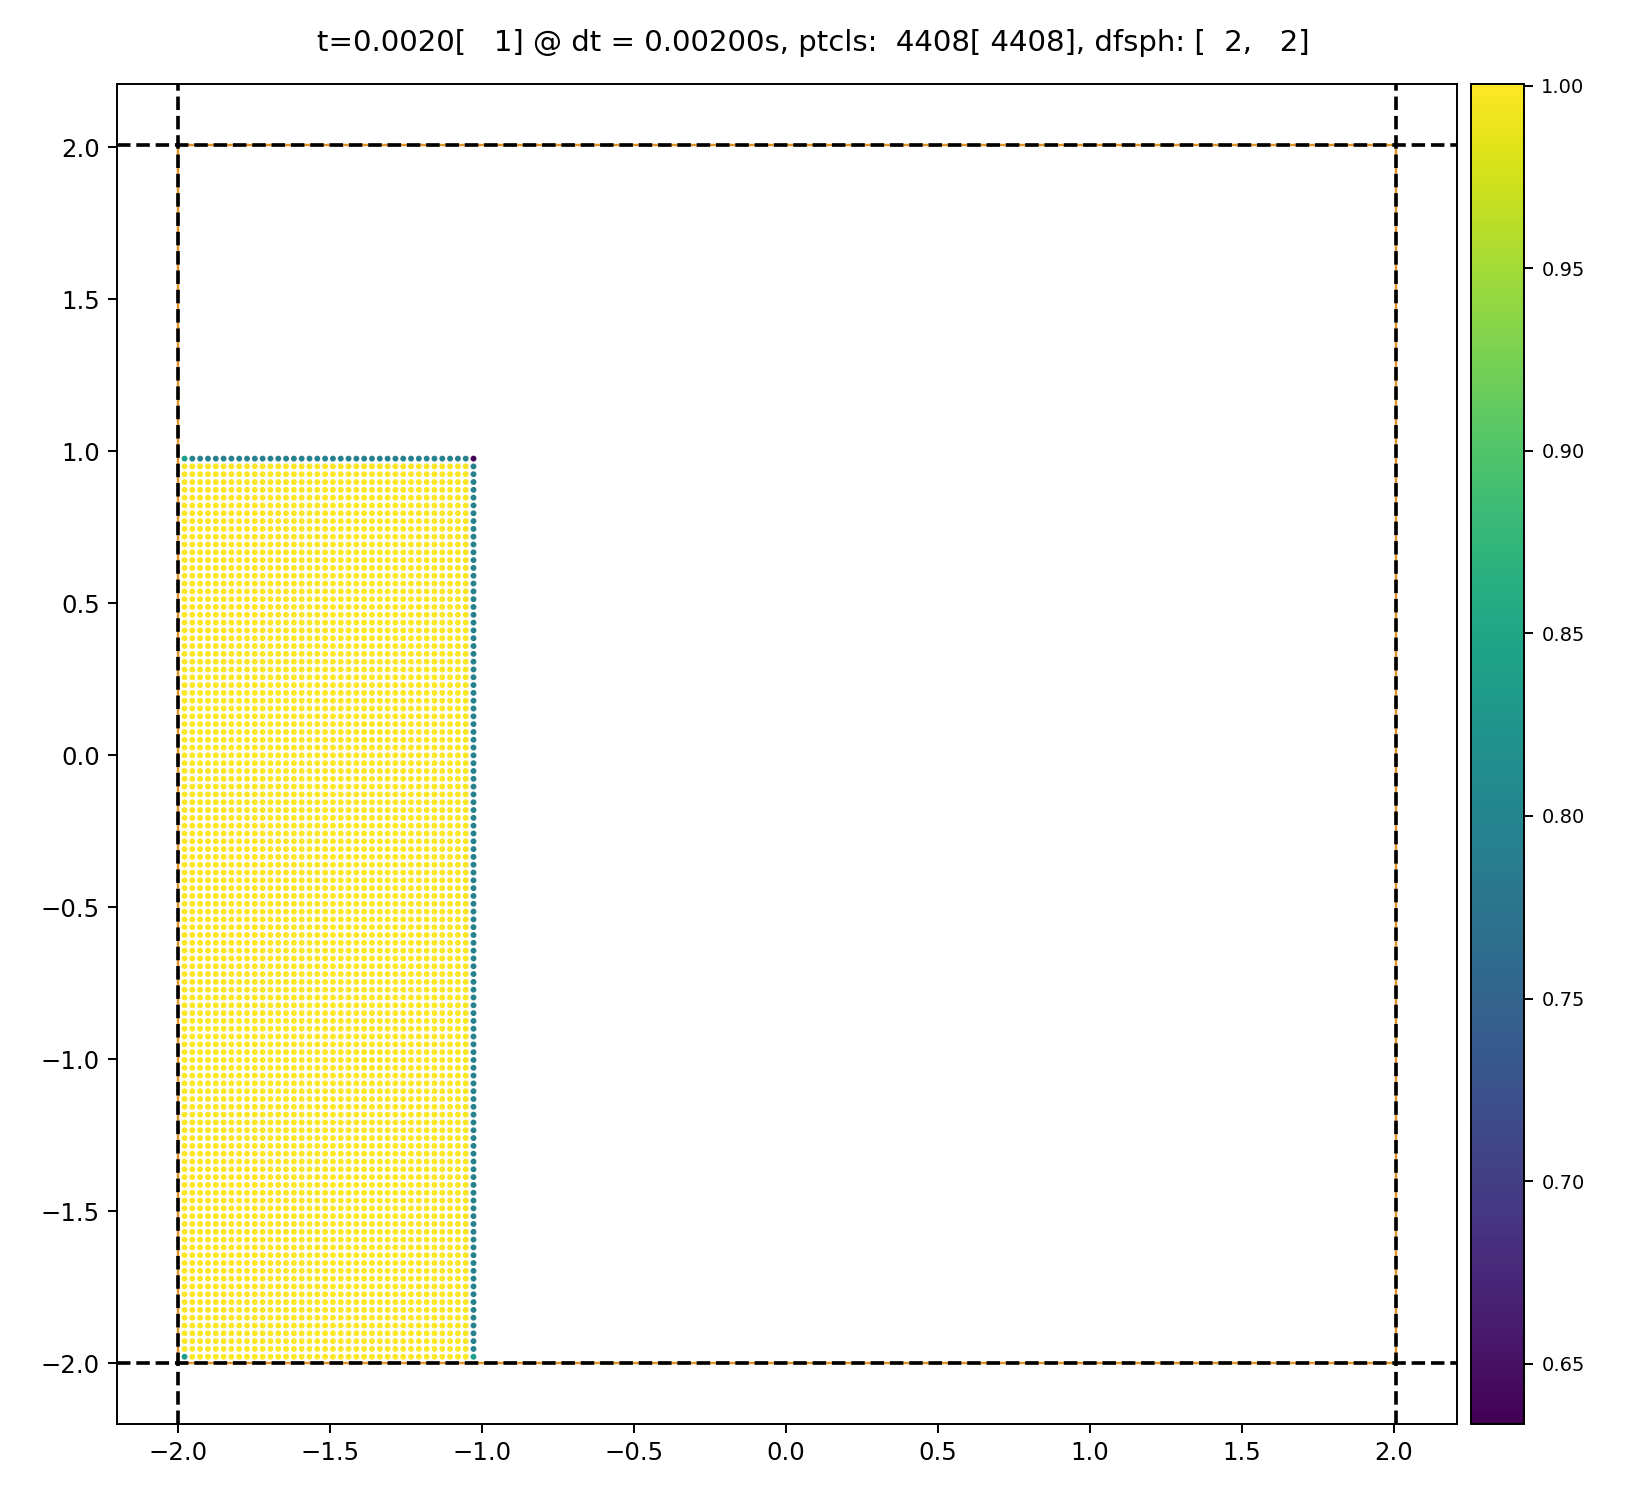

In [216]:
fig, axis = sphSimulation.createPlot(plotScale = 2)

state = sphSimulation.simulationState

positions = state['fluidPosition'].detach().cpu().numpy()
# colors = torch.linalg.norm(state['fluidVelocity'].detach(),axis=1).cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()


sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()

In [86]:
for i in range(512):
    sphSimulation.timestep()

    
    positions = state['fluidPosition'].detach().cpu().numpy()
    # colors = torch.linalg.norm(state['fluidVelocity'].detach(),axis=1).cpu().numpy()
    data = state['fluidPressure'].detach().cpu().numpy()

    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


    if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
        raise Exception('Simulation borked')